## Imports and Configuration

In [1]:
!pip install -U albumentations --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 369.4/369.4 kB 8.9 MB/s eta 0:00:00


In [2]:
import os
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# --- DATASET DEFINITION ---

class SheepDataset(Dataset):
    def __init__(self, df=None, image_dir=None, transform=None, is_test=False):
        self.image_dir = image_dir
        self.transform = transform
        self.is_test = is_test

        if self.is_test:
            # For test set, just get sorted list of image files
            self.img_files = sorted(os.listdir(image_dir))
        else:
            # For train/val set, use dataframe with filenames and labels
            self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.img_files) if self.is_test else len(self.df)

    def __getitem__(self, idx):
        if self.is_test:
            filename = self.img_files[idx]
            img_path = os.path.join(self.image_dir, filename)
            image = Image.open(img_path).convert('RGB')
            image = np.array(image)
            if self.transform:
                image = self.transform(image=image)['image']
            return image, filename
        else:
            row = self.df.iloc[idx]
            img_path = os.path.join(self.image_dir, row['filename'])
            image = Image.open(img_path).convert('RGB')
            image = np.array(image)
            if self.transform:
                image = self.transform(image=image)['image']
            label = row['label']
            return image, torch.tensor(label, dtype=torch.long)


# --- Data Augmentation ---

def get_train_transforms():
    return A.Compose([
        A.Resize(CFG.img_size, CFG.img_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.RandomRotate90(p=0.3),
        A.Affine(p=0.6, translate_percent=0.15, scale=(0.85, 1.15), rotate=(-30, 30)),
        A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.15, p=0.6),
        A.OneOf([
            A.MotionBlur(p=1.0),
            A.GaussianBlur(blur_limit=(3,9), p=1.0),
        ], p=0.3),
        A.OneOf([
            A.GridDistortion(p=1.0),
            A.OpticalDistortion(distort_limit=0.1, p=1.0),
        ], p=0.2),
        A.CoarseDropout(p=0.4),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2()
    ])

def get_valid_transforms():
    return A.Compose([
        A.Resize(CFG.img_size, CFG.img_size),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2()
    ])


# --- MODEL, LOSS AND UTILITIES ---

class ViTClassifier(nn.Module):
    def __init__(self, backbone_name, num_classes, dropout_rate=0.4):
        super().__init__()
        self.backbone = timm.create_model(backbone_name, pretrained=True)
        in_features = self.backbone.num_features
        self.backbone.reset_classifier(0)  # Remove default classifier head
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 1024),
            nn.BatchNorm1d(1024),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(dropout_rate * 0.7),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(256, num_classes)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)
    

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(inputs, targets, weight=self.alpha, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss
    
    
def get_optimizer_scheduler(model, train_loader, epochs):
    """
    An optimizer and a learning rate scheduler
    with different learning rates for backbone
    and head
    Uses AdamW optimizer, CosineAnnealingWarmRestarts scheduler
    """
    param_groups = [
        {'params': model.backbone.parameters(), 'lr': CFG.lr * 0.1}, # Backbone with lower LR
        {'params': model.classifier.parameters(), 'lr': CFG.lr} # Classifier with base LR
    ]

    optimizer = torch.optim.AdamW(
        param_groups, 
        weight_decay=0.01,
        betas=(0.9, 0.999),
        eps=1e-8
    )

    # Cosine annealing with warm restarts
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, 
        T_0=len(train_loader) * 3,  # Restart every 3 epochs
        T_mult=2,
        eta_min=CFG.min_lr
    )

    return optimizer, scheduler


# --- TRAINING AND EVALUATION FUNCTIONS ---

def train_one_epoch(model, loader, optimizer, criterion, scheduler, scaler, epoch):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc=f'Epoch {epoch+1}')
    for images, labels in pbar:
        images = images.to(CFG.device)
        labels = labels.to(CFG.device)

        optimizer.zero_grad()

        with torch.amp.autocast(device_type=CFG.device):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()

        # Gradient clipping
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })

    return total_loss / len(loader), 100. * correct / total

def evaluate(model, loader, criterion=None, class_report=False):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    correct = 0
    total = 0
    report_txt = "" 

    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validating'):
            images = images.to(CFG.device)
            labels = labels.to(CFG.device)

            with torch.amp.autocast(device_type=CFG.device):
                outputs = model(images)
                if criterion is not None:
                    loss = criterion(outputs, labels)
                    total_loss += loss.item()

            preds = torch.argmax(outputs, 1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    f1_macro = f1_score(all_labels, all_preds, average='macro')
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')

    accuracy = correct / total if total > 0 else 0
    avg_loss = total_loss / len(loader) if criterion is not None else 0

    if class_report:
        print(f"\n------------ Classification Report ------------")
        report = classification_report(all_labels, all_preds, digits=4, output_dict=True)
        df_report = pd.DataFrame(report).T
        report_txt = classification_report(all_labels, all_preds, digits=4)
        display(df_report.style.background_gradient(cmap='Blues'))


    return f1_macro, f1_weighted, accuracy, avg_loss, report_txt


# --- EARLY STOPPING & CLASS WEIGHTS ---

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_score = None
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_score, model):
        if self.best_score is None:
            self.best_score = val_score
            self.save_checkpoint(model)
        elif val_score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                if self.restore_best_weights:
                    model.load_state_dict(self.best_weights)
                return True
        else:
            self.best_score = val_score
            self.counter = 0
            self.save_checkpoint(model)
        return False

    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()


def compute_class_weights(labels, method='balanced'):
    from sklearn.utils.class_weight import compute_class_weight
    classes = np.unique(labels)

    if method == 'balanced':
        weights = compute_class_weight('balanced', classes=classes, y=labels)
    elif method == 'effective':
        beta = 0.9999
        effective_num = 1.0 - np.power(beta, np.bincount(labels))
        weights = (1.0 - beta) / np.array(effective_num)
        weights = weights / weights.sum() * len(classes)

    return torch.tensor(weights, dtype=torch.float)


# --- VISUALIZATION ---

def plot_metrics(history, save_name):
    sns.set_style("darkgrid")
    colors = {"val": "#084d02"}

    # Make all metrics same length (minimum length across)
    min_len = min(len(v) for v in history.values())
    for k in history:
        history[k] = history[k][:min_len]
    epochs = range(1, min_len + 1)

    fig, axes = plt.subplots(1, 4, figsize=(24, 5))  # 1 row, 4 columns

    # Validation Loss
    ax = axes[0]
    ax.plot(
        epochs,
        history["val_loss"],
        marker="s",
        markersize=6,
        linewidth=2,
        color=colors["val"],
        label="Validation",
    )
    ax.set_title("Validation Loss", fontsize=14, fontweight="bold")
    ax.set_xlabel("Epoch", fontsize=12)
    ax.set_ylabel("Loss", fontsize=12)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend(loc="upper right", frameon=True, fontsize=11)
    ax.grid(True, linestyle="--", alpha=0.6)

    # Validation Acc
    ax = axes[1]
    ax.plot(
        epochs,
        history["val_acc"],
        marker="s",
        markersize=6,
        linewidth=2,
        color=colors["val"],
        label="Validation",
    )
    ax.set_title("Validation Accuracy", fontsize=14, fontweight="bold")
    ax.set_xlabel("Epoch", fontsize=12)
    ax.set_ylabel("Accuracy", fontsize=12)
    ax.set_ylim(0, 1)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend(loc="lower right", frameon=True, fontsize=11)
    ax.grid(True, linestyle="--", alpha=0.6)

    # F1 Macro Score
    ax = axes[2]
    ax.plot(
        epochs,
        history["val_f1_macro"],
        marker="o",
        markersize=6,
        linewidth=2,
        color=colors["val"],
        label="F1 Macro",
    )
    ax.set_title("F1 Macro Score", fontsize=14, fontweight="bold")
    ax.set_xlabel("Epoch", fontsize=12)
    ax.set_ylabel("F1 Score", fontsize=12)
    ax.set_ylim(0, 1)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend(loc="lower right", frameon=True, fontsize=11)
    ax.grid(True, linestyle="--", alpha=0.6)

    # F1 Weighted Score
    ax = axes[3]
    ax.plot(
        epochs,
        history["val_f1_weighted"],
        marker="D",
        markersize=6,
        linewidth=2,
        color=colors["val"],
        label="F1 Weighted",
    )
    ax.set_title("F1 Weighted Score", fontsize=14, fontweight="bold")
    ax.set_xlabel("Epoch", fontsize=12)
    ax.set_ylabel("F1 Score", fontsize=12)
    ax.set_ylim(0, 1)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend(loc="lower right", frameon=True, fontsize=11)
    ax.grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.savefig(
        os.path.join(CFG.results_dir, save_name), 
        format="png", 
        dpi=300, 
        bbox_inches="tight"
    )
    plt.show()

    return fig

## Configuration

Lets set up global configuration that we will use through this notebook, centralizes all setting, and create directories for models and results.

In [4]:
# --- CONFIG ---

class CFG:
    seed = 742
    img_size = 224
    model_name = 'vit_base_patch16_224.augreg_in21k_ft_in1k'
    num_classes = 7
    batch_size = 16
    epochs = 25 # 20
    lr = 1e-4
    min_lr = 1e-6
    n_folds = 7 # 5
    patience = 7 # 5
    train_csv = '/kaggle/input/sheep-classification-challenge-2025/Sheep Classification Images/train_labels.csv'
    train_dir = '/kaggle/input/sheep-classification-challenge-2025/Sheep Classification Images/train'
    test_dir = '/kaggle/input/sheep-classification-challenge-2025/Sheep Classification Images/test'
    models_dir = '/kaggle/working/models'
    results_dir = '/kaggle/working/results'
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

os.makedirs(CFG.models_dir, exist_ok=True)
os.makedirs(CFG.results_dir, exist_ok=True)

In [5]:
# setting seeds for reproducibility
torch.manual_seed(CFG.seed) 
np.random.seed(CFG.seed)

## Load Dataset and Prepare Labels

Read the CSV, encode class labels, and compute class weights.

In [6]:
df = pd.read_csv(CFG.train_csv)

label2idx = {label: i for i, label in enumerate(sorted(df['label'].unique()))}
# idx2label = {v: k for k, v in label2idx.items()}
df['label'] = df['label'].map(label2idx)

class_weights = compute_class_weights(df['label'].values, method='effective').to(CFG.device)
print(f"Class weights: {class_weights}")

Class weights: tensor([2.0280, 0.6658, 1.1464, 0.2814, 1.0015, 0.9877, 0.8892],
       device='cuda:0')


## Model Definition

In [7]:
model = ViTClassifier(CFG.model_name, CFG.num_classes).to(CFG.device)
summary(model, (3, CFG.img_size, CFG.img_size))

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
          Identity-2             [-1, 196, 768]               0
        PatchEmbed-3             [-1, 196, 768]               0
           Dropout-4             [-1, 197, 768]               0
          Identity-5             [-1, 197, 768]               0
          Identity-6             [-1, 197, 768]               0
         LayerNorm-7             [-1, 197, 768]           1,536
            Linear-8            [-1, 197, 2304]       1,771,776
          Identity-9          [-1, 12, 197, 64]               0
         Identity-10          [-1, 12, 197, 64]               0
           Linear-11             [-1, 197, 768]         590,592
          Dropout-12             [-1, 197, 768]               0
        Attention-13             [-1, 197, 768]               0
         Identity-14             [-1, 1

## Cross-Validation Training

We'll train with Stratified K-Fold cross-validation and log performance metrics.

In [8]:
criterion = FocalLoss(alpha=class_weights, gamma=2.0)
skf = StratifiedKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)


---------------------------------------------- Fold 1 ----------------------------------------------
Train distribution: [30, 92, 53, 218, 61, 62, 68]
Val distribution: [5, 15, 9, 37, 10, 10, 12]


Validating: 100%|██████████| 7/7 [00:00<00:00, 11.12it/s]


Fold 1 | Epoch 1 | Train Loss: 1.0951 | Train Acc: 15.45% | Val Loss: 0.5862 | Val Acc: 0.4796 | Val F1 Macro: 0.4695 | Val F1 Weighted: 0.4585


Validating: 100%|██████████| 7/7 [00:00<00:00, 11.02it/s]


Fold 1 | Epoch 2 | Train Loss: 0.7361 | Train Acc: 30.90% | Val Loss: 0.4129 | Val Acc: 0.5714 | Val F1 Macro: 0.5698 | Val F1 Weighted: 0.5370


Validating: 100%|██████████| 7/7 [00:00<00:00, 11.38it/s]


Fold 1 | Epoch 3 | Train Loss: 0.6083 | Train Acc: 37.85% | Val Loss: 0.3570 | Val Acc: 0.6020 | Val F1 Macro: 0.5972 | Val F1 Weighted: 0.5762


Validating: 100%|██████████| 7/7 [00:00<00:00, 12.10it/s]


Fold 1 | Epoch 4 | Train Loss: 0.4628 | Train Acc: 47.74% | Val Loss: 0.1682 | Val Acc: 0.6735 | Val F1 Macro: 0.6642 | Val F1 Weighted: 0.6495


Validating: 100%|██████████| 7/7 [00:00<00:00, 12.11it/s]


Fold 1 | Epoch 5 | Train Loss: 0.2754 | Train Acc: 59.55% | Val Loss: 0.1201 | Val Acc: 0.7959 | Val F1 Macro: 0.7930 | Val F1 Weighted: 0.8075


Validating: 100%|██████████| 7/7 [00:00<00:00, 11.28it/s]


Fold 1 | Epoch 6 | Train Loss: 0.2203 | Train Acc: 65.10% | Val Loss: 0.0928 | Val Acc: 0.8367 | Val F1 Macro: 0.8338 | Val F1 Weighted: 0.8450


Validating: 100%|██████████| 7/7 [00:00<00:00, 11.84it/s]


Fold 1 | Epoch 7 | Train Loss: 0.1796 | Train Acc: 68.40% | Val Loss: 0.0699 | Val Acc: 0.8265 | Val F1 Macro: 0.8212 | Val F1 Weighted: 0.8365


Validating: 100%|██████████| 7/7 [00:00<00:00, 11.76it/s]


Fold 1 | Epoch 8 | Train Loss: 0.1559 | Train Acc: 71.53% | Val Loss: 0.0683 | Val Acc: 0.8673 | Val F1 Macro: 0.8597 | Val F1 Weighted: 0.8741


Validating: 100%|██████████| 7/7 [00:00<00:00, 11.32it/s]


Fold 1 | Epoch 9 | Train Loss: 0.1291 | Train Acc: 73.09% | Val Loss: 0.0638 | Val Acc: 0.8469 | Val F1 Macro: 0.8471 | Val F1 Weighted: 0.8596


Validating: 100%|██████████| 7/7 [00:00<00:00, 11.66it/s]


Fold 1 | Epoch 10 | Train Loss: 0.1379 | Train Acc: 77.78% | Val Loss: 0.0721 | Val Acc: 0.8878 | Val F1 Macro: 0.8752 | Val F1 Weighted: 0.8865


Validating: 100%|██████████| 7/7 [00:00<00:00, 10.81it/s]


Fold 1 | Epoch 11 | Train Loss: 0.1109 | Train Acc: 81.60% | Val Loss: 0.0516 | Val Acc: 0.9184 | Val F1 Macro: 0.9030 | Val F1 Weighted: 0.9156


Validating: 100%|██████████| 7/7 [00:00<00:00, 11.45it/s]


Fold 1 | Epoch 12 | Train Loss: 0.1026 | Train Acc: 85.24% | Val Loss: 0.0281 | Val Acc: 0.9388 | Val F1 Macro: 0.9236 | Val F1 Weighted: 0.9380


Validating: 100%|██████████| 7/7 [00:00<00:00, 11.37it/s]


Fold 1 | Epoch 13 | Train Loss: 0.0554 | Train Acc: 89.76% | Val Loss: 0.0289 | Val Acc: 0.9388 | Val F1 Macro: 0.9307 | Val F1 Weighted: 0.9368


Validating: 100%|██████████| 7/7 [00:00<00:00, 11.32it/s]


Fold 1 | Epoch 14 | Train Loss: 0.0488 | Train Acc: 90.10% | Val Loss: 0.0198 | Val Acc: 0.9694 | Val F1 Macro: 0.9599 | Val F1 Weighted: 0.9692


Validating: 100%|██████████| 7/7 [00:00<00:00, 10.90it/s]


Fold 1 | Epoch 15 | Train Loss: 0.0513 | Train Acc: 89.58% | Val Loss: 0.0303 | Val Acc: 0.9592 | Val F1 Macro: 0.9568 | Val F1 Weighted: 0.9591


Validating: 100%|██████████| 7/7 [00:00<00:00, 10.81it/s]


Fold 1 | Epoch 16 | Train Loss: 0.0433 | Train Acc: 90.97% | Val Loss: 0.0287 | Val Acc: 0.9694 | Val F1 Macro: 0.9655 | Val F1 Weighted: 0.9691


Validating: 100%|██████████| 7/7 [00:00<00:00, 10.97it/s]


Fold 1 | Epoch 17 | Train Loss: 0.0417 | Train Acc: 93.75% | Val Loss: 0.0159 | Val Acc: 0.9592 | Val F1 Macro: 0.9568 | Val F1 Weighted: 0.9591


Validating: 100%|██████████| 7/7 [00:00<00:00, 10.76it/s]


Fold 1 | Epoch 18 | Train Loss: 0.0454 | Train Acc: 93.06% | Val Loss: 0.0263 | Val Acc: 0.9694 | Val F1 Macro: 0.9599 | Val F1 Weighted: 0.9692


Validating: 100%|██████████| 7/7 [00:00<00:00, 11.12it/s]


Fold 1 | Epoch 19 | Train Loss: 0.0358 | Train Acc: 94.27% | Val Loss: 0.0304 | Val Acc: 0.9592 | Val F1 Macro: 0.9523 | Val F1 Weighted: 0.9582


Validating: 100%|██████████| 7/7 [00:00<00:00, 11.21it/s]


Fold 1 | Epoch 20 | Train Loss: 0.0290 | Train Acc: 94.97% | Val Loss: 0.0280 | Val Acc: 0.9694 | Val F1 Macro: 0.9655 | Val F1 Weighted: 0.9691


Validating: 100%|██████████| 7/7 [00:00<00:00, 11.12it/s]


Fold 1 | Epoch 21 | Train Loss: 0.0279 | Train Acc: 94.79% | Val Loss: 0.0256 | Val Acc: 0.9796 | Val F1 Macro: 0.9727 | Val F1 Weighted: 0.9797


Validating: 100%|██████████| 7/7 [00:00<00:00, 11.58it/s]


Fold 1 | Epoch 22 | Train Loss: 0.0190 | Train Acc: 95.66% | Val Loss: 0.0104 | Val Acc: 0.9694 | Val F1 Macro: 0.9694 | Val F1 Weighted: 0.9695


Validating: 100%|██████████| 7/7 [00:00<00:00, 11.38it/s]


Fold 1 | Epoch 23 | Train Loss: 0.0295 | Train Acc: 95.49% | Val Loss: 0.0266 | Val Acc: 0.9592 | Val F1 Macro: 0.9559 | Val F1 Weighted: 0.9586


Validating: 100%|██████████| 7/7 [00:00<00:00, 11.11it/s]


Fold 1 | Epoch 24 | Train Loss: 0.0312 | Train Acc: 94.62% | Val Loss: 0.0173 | Val Acc: 0.9694 | Val F1 Macro: 0.9630 | Val F1 Weighted: 0.9687


Validating: 100%|██████████| 7/7 [00:00<00:00, 11.51it/s]



------------ Classification Report ------------


Fold 1 | Epoch 25 | Train Loss: 0.0348 | Train Acc: 95.49% | Val Loss: 0.0057 | Val Acc: 0.9898 | Val F1 Macro: 0.9912 | Val F1 Weighted: 0.9900


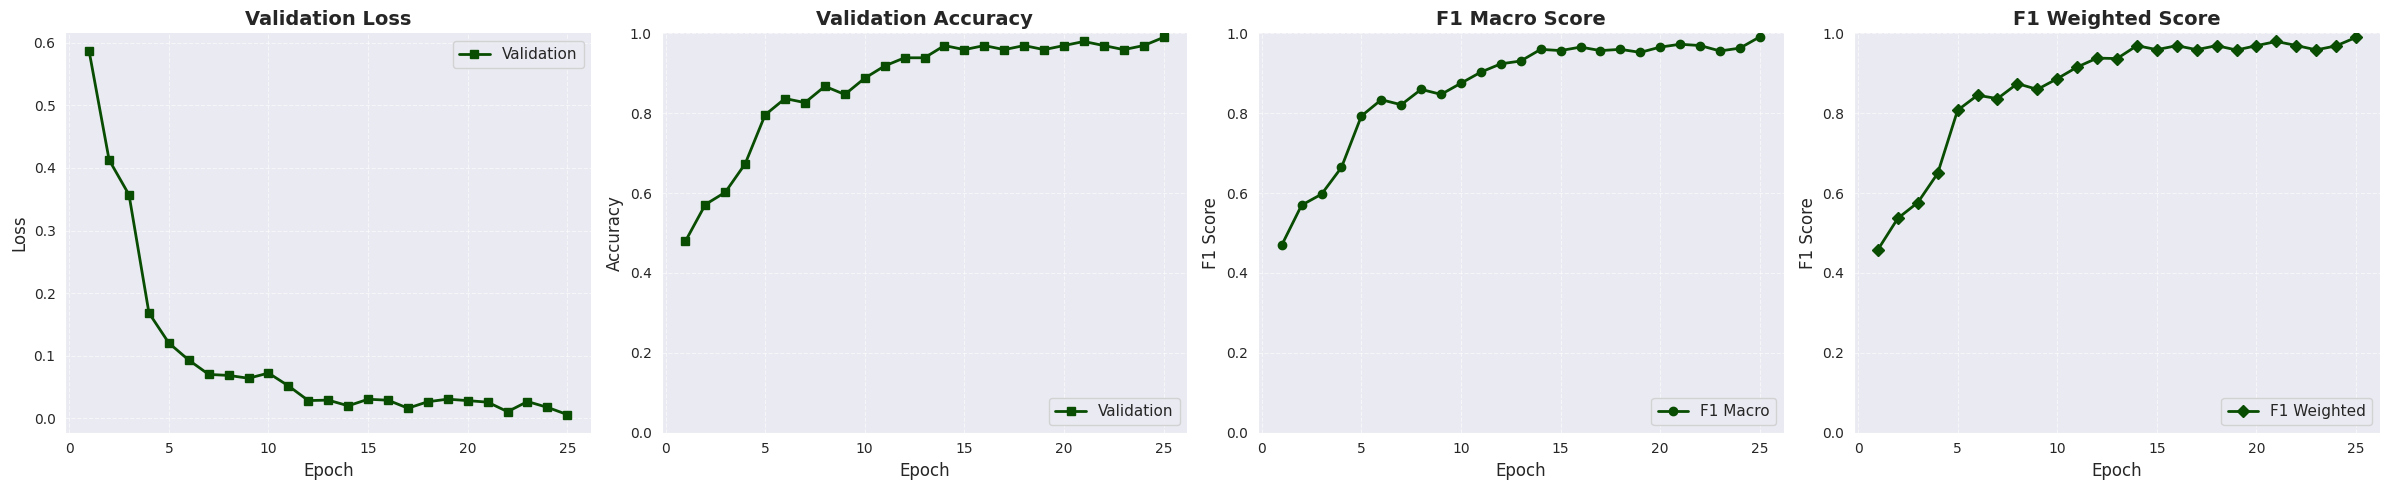

Fold 1 best F1: 0.9912

---------------------------------------------- Fold 2 ----------------------------------------------
Train distribution: [30, 92, 53, 218, 61, 62, 68]
Val distribution: [5, 15, 9, 37, 10, 10, 12]


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.36it/s]


Fold 2 | Epoch 1 | Train Loss: 1.0828 | Train Acc: 17.01% | Val Loss: 0.4271 | Val Acc: 0.4796 | Val F1 Macro: 0.4928 | Val F1 Weighted: 0.4498


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.63it/s]


Fold 2 | Epoch 2 | Train Loss: 0.7209 | Train Acc: 31.60% | Val Loss: 0.2684 | Val Acc: 0.5714 | Val F1 Macro: 0.6038 | Val F1 Weighted: 0.5403


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.67it/s]


Fold 2 | Epoch 3 | Train Loss: 0.6037 | Train Acc: 39.41% | Val Loss: 0.2517 | Val Acc: 0.5816 | Val F1 Macro: 0.6144 | Val F1 Weighted: 0.5616


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.59it/s]


Fold 2 | Epoch 4 | Train Loss: 0.5514 | Train Acc: 38.19% | Val Loss: 0.1294 | Val Acc: 0.7347 | Val F1 Macro: 0.7463 | Val F1 Weighted: 0.7367


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.71it/s]


Fold 2 | Epoch 5 | Train Loss: 0.3145 | Train Acc: 55.03% | Val Loss: 0.1007 | Val Acc: 0.7959 | Val F1 Macro: 0.8013 | Val F1 Weighted: 0.7999


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.66it/s]


Fold 2 | Epoch 6 | Train Loss: 0.2586 | Train Acc: 59.90% | Val Loss: 0.0747 | Val Acc: 0.8367 | Val F1 Macro: 0.8289 | Val F1 Weighted: 0.8423


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.60it/s]


Fold 2 | Epoch 7 | Train Loss: 0.1891 | Train Acc: 66.32% | Val Loss: 0.0680 | Val Acc: 0.8673 | Val F1 Macro: 0.8622 | Val F1 Weighted: 0.8709


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.61it/s]


Fold 2 | Epoch 8 | Train Loss: 0.1765 | Train Acc: 68.40% | Val Loss: 0.0647 | Val Acc: 0.8673 | Val F1 Macro: 0.8660 | Val F1 Weighted: 0.8708


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.83it/s]


Fold 2 | Epoch 9 | Train Loss: 0.1415 | Train Acc: 72.40% | Val Loss: 0.0735 | Val Acc: 0.8571 | Val F1 Macro: 0.8470 | Val F1 Weighted: 0.8625


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.58it/s]


Fold 2 | Epoch 10 | Train Loss: 0.1511 | Train Acc: 74.83% | Val Loss: 0.0417 | Val Acc: 0.8878 | Val F1 Macro: 0.8795 | Val F1 Weighted: 0.8921


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.63it/s]


Fold 2 | Epoch 11 | Train Loss: 0.1577 | Train Acc: 79.17% | Val Loss: 0.0592 | Val Acc: 0.8980 | Val F1 Macro: 0.8915 | Val F1 Weighted: 0.8987


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.04it/s]


Fold 2 | Epoch 12 | Train Loss: 0.1146 | Train Acc: 81.77% | Val Loss: 0.0513 | Val Acc: 0.8878 | Val F1 Macro: 0.8862 | Val F1 Weighted: 0.8913


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.95it/s]


Fold 2 | Epoch 13 | Train Loss: 0.0907 | Train Acc: 85.76% | Val Loss: 0.0750 | Val Acc: 0.8878 | Val F1 Macro: 0.8825 | Val F1 Weighted: 0.8926


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.48it/s]


Fold 2 | Epoch 14 | Train Loss: 0.0801 | Train Acc: 87.15% | Val Loss: 0.0666 | Val Acc: 0.9286 | Val F1 Macro: 0.9244 | Val F1 Weighted: 0.9291


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.17it/s]


Fold 2 | Epoch 15 | Train Loss: 0.0529 | Train Acc: 90.45% | Val Loss: 0.0627 | Val Acc: 0.9388 | Val F1 Macro: 0.9362 | Val F1 Weighted: 0.9396


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.73it/s]


Fold 2 | Epoch 16 | Train Loss: 0.0399 | Train Acc: 90.80% | Val Loss: 0.0636 | Val Acc: 0.9286 | Val F1 Macro: 0.9286 | Val F1 Weighted: 0.9302


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.51it/s]


Fold 2 | Epoch 17 | Train Loss: 0.0392 | Train Acc: 91.32% | Val Loss: 0.0801 | Val Acc: 0.9286 | Val F1 Macro: 0.9244 | Val F1 Weighted: 0.9291


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.68it/s]


Fold 2 | Epoch 18 | Train Loss: 0.0318 | Train Acc: 93.92% | Val Loss: 0.0677 | Val Acc: 0.9286 | Val F1 Macro: 0.9286 | Val F1 Weighted: 0.9302


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.67it/s]


Fold 2 | Epoch 19 | Train Loss: 0.0365 | Train Acc: 93.75% | Val Loss: 0.0727 | Val Acc: 0.9286 | Val F1 Macro: 0.9286 | Val F1 Weighted: 0.9302


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.37it/s]


Fold 2 | Epoch 20 | Train Loss: 0.0197 | Train Acc: 94.10% | Val Loss: 0.0661 | Val Acc: 0.9286 | Val F1 Macro: 0.9286 | Val F1 Weighted: 0.9302


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.85it/s]


Fold 2 | Epoch 21 | Train Loss: 0.0495 | Train Acc: 93.06% | Val Loss: 0.0667 | Val Acc: 0.9286 | Val F1 Macro: 0.9286 | Val F1 Weighted: 0.9302


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.74it/s]


Fold 2 | Epoch 22 | Train Loss: 0.0351 | Train Acc: 94.27% | Val Loss: 0.0775 | Val Acc: 0.9184 | Val F1 Macro: 0.9266 | Val F1 Weighted: 0.9218
Early stopping at epoch 21


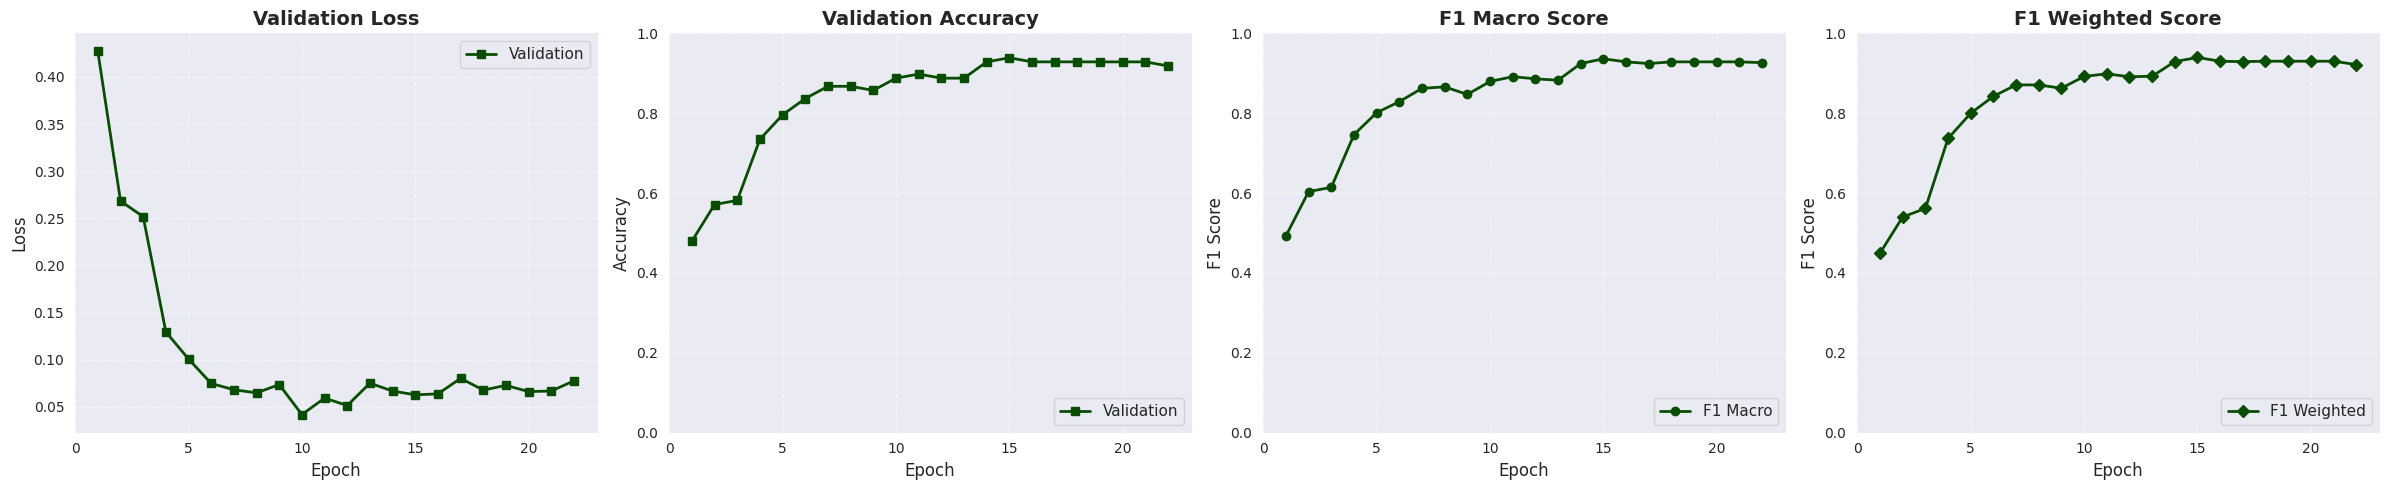

Fold 2 best F1: 0.9362

---------------------------------------------- Fold 3 ----------------------------------------------
Train distribution: [30, 92, 53, 218, 60, 62, 69]
Val distribution: [5, 15, 9, 37, 11, 10, 11]


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.96it/s]


Fold 3 | Epoch 1 | Train Loss: 1.0598 | Train Acc: 22.05% | Val Loss: 0.4583 | Val Acc: 0.4184 | Val F1 Macro: 0.4330 | Val F1 Weighted: 0.3953


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.35it/s]


Fold 3 | Epoch 2 | Train Loss: 0.7259 | Train Acc: 36.81% | Val Loss: 0.3415 | Val Acc: 0.5102 | Val F1 Macro: 0.5586 | Val F1 Weighted: 0.4740


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.98it/s]


Fold 3 | Epoch 3 | Train Loss: 0.5991 | Train Acc: 42.53% | Val Loss: 0.2922 | Val Acc: 0.5612 | Val F1 Macro: 0.6065 | Val F1 Weighted: 0.5254


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.31it/s]


Fold 3 | Epoch 4 | Train Loss: 0.4765 | Train Acc: 49.31% | Val Loss: 0.1624 | Val Acc: 0.7347 | Val F1 Macro: 0.7618 | Val F1 Weighted: 0.7399


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.10it/s]


Fold 3 | Epoch 5 | Train Loss: 0.3227 | Train Acc: 59.55% | Val Loss: 0.1086 | Val Acc: 0.7857 | Val F1 Macro: 0.8021 | Val F1 Weighted: 0.7985


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.97it/s]


Fold 3 | Epoch 6 | Train Loss: 0.2190 | Train Acc: 67.36% | Val Loss: 0.0927 | Val Acc: 0.8367 | Val F1 Macro: 0.8194 | Val F1 Weighted: 0.8401


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.27it/s]


Fold 3 | Epoch 7 | Train Loss: 0.1917 | Train Acc: 70.14% | Val Loss: 0.0812 | Val Acc: 0.8980 | Val F1 Macro: 0.8922 | Val F1 Weighted: 0.9011


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.41it/s]


Fold 3 | Epoch 8 | Train Loss: 0.1573 | Train Acc: 72.92% | Val Loss: 0.0759 | Val Acc: 0.8878 | Val F1 Macro: 0.8805 | Val F1 Weighted: 0.8891


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.05it/s]


Fold 3 | Epoch 9 | Train Loss: 0.1267 | Train Acc: 76.04% | Val Loss: 0.0766 | Val Acc: 0.8878 | Val F1 Macro: 0.8808 | Val F1 Weighted: 0.8889


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.11it/s]


Fold 3 | Epoch 10 | Train Loss: 0.1422 | Train Acc: 74.83% | Val Loss: 0.0805 | Val Acc: 0.9286 | Val F1 Macro: 0.9183 | Val F1 Weighted: 0.9286


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.20it/s]


Fold 3 | Epoch 11 | Train Loss: 0.1123 | Train Acc: 81.60% | Val Loss: 0.0766 | Val Acc: 0.9388 | Val F1 Macro: 0.9302 | Val F1 Weighted: 0.9396


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.93it/s]


Fold 3 | Epoch 12 | Train Loss: 0.1110 | Train Acc: 80.56% | Val Loss: 0.1186 | Val Acc: 0.9184 | Val F1 Macro: 0.8980 | Val F1 Weighted: 0.9176


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.50it/s]


Fold 3 | Epoch 13 | Train Loss: 0.0783 | Train Acc: 85.42% | Val Loss: 0.0880 | Val Acc: 0.9286 | Val F1 Macro: 0.9155 | Val F1 Weighted: 0.9294


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.19it/s]


Fold 3 | Epoch 14 | Train Loss: 0.0697 | Train Acc: 87.50% | Val Loss: 0.0949 | Val Acc: 0.9286 | Val F1 Macro: 0.9190 | Val F1 Weighted: 0.9306


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.32it/s]


Fold 3 | Epoch 15 | Train Loss: 0.0761 | Train Acc: 88.37% | Val Loss: 0.0982 | Val Acc: 0.9490 | Val F1 Macro: 0.9392 | Val F1 Weighted: 0.9486


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.37it/s]


Fold 3 | Epoch 16 | Train Loss: 0.0527 | Train Acc: 90.97% | Val Loss: 0.0872 | Val Acc: 0.9592 | Val F1 Macro: 0.9493 | Val F1 Weighted: 0.9594


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.41it/s]


Fold 3 | Epoch 17 | Train Loss: 0.0508 | Train Acc: 91.67% | Val Loss: 0.0889 | Val Acc: 0.9592 | Val F1 Macro: 0.9493 | Val F1 Weighted: 0.9594


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.12it/s]


Fold 3 | Epoch 18 | Train Loss: 0.0295 | Train Acc: 92.71% | Val Loss: 0.1006 | Val Acc: 0.9490 | Val F1 Macro: 0.9337 | Val F1 Weighted: 0.9489


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.18it/s]


Fold 3 | Epoch 19 | Train Loss: 0.0395 | Train Acc: 91.84% | Val Loss: 0.0848 | Val Acc: 0.9592 | Val F1 Macro: 0.9493 | Val F1 Weighted: 0.9594


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.91it/s]


Fold 3 | Epoch 20 | Train Loss: 0.0381 | Train Acc: 93.23% | Val Loss: 0.0829 | Val Acc: 0.9592 | Val F1 Macro: 0.9493 | Val F1 Weighted: 0.9594


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.49it/s]


Fold 3 | Epoch 21 | Train Loss: 0.0515 | Train Acc: 92.19% | Val Loss: 0.0921 | Val Acc: 0.9490 | Val F1 Macro: 0.9337 | Val F1 Weighted: 0.9489


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.49it/s]


Fold 3 | Epoch 22 | Train Loss: 0.0661 | Train Acc: 91.84% | Val Loss: 0.1013 | Val Acc: 0.9388 | Val F1 Macro: 0.9260 | Val F1 Weighted: 0.9392


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.46it/s]


Fold 3 | Epoch 23 | Train Loss: 0.0371 | Train Acc: 91.15% | Val Loss: 0.0791 | Val Acc: 0.9490 | Val F1 Macro: 0.9412 | Val F1 Weighted: 0.9497
Early stopping at epoch 22


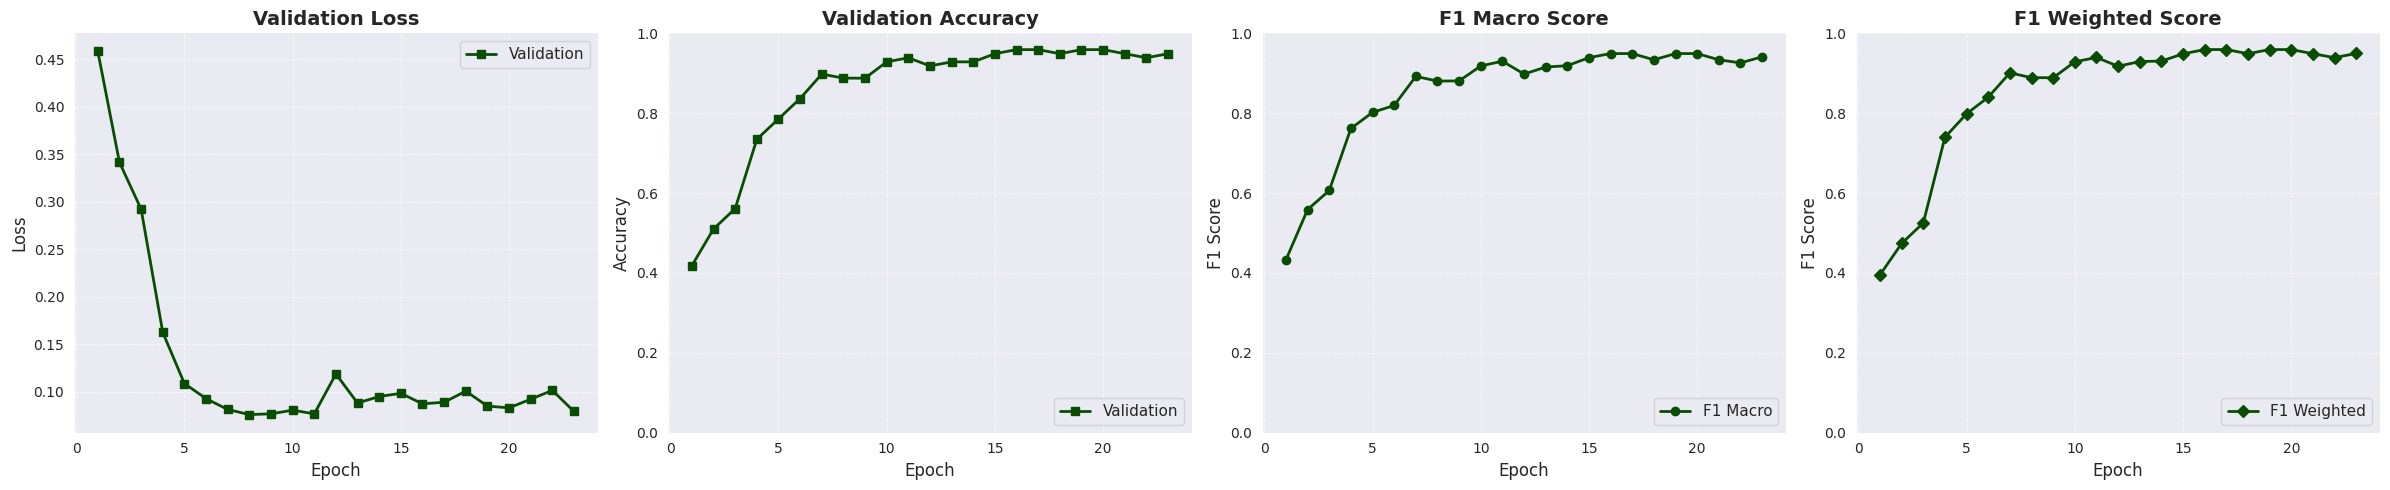

Fold 3 best F1: 0.9493

---------------------------------------------- Fold 4 ----------------------------------------------
Train distribution: [30, 91, 53, 219, 61, 62, 69]
Val distribution: [5, 16, 9, 36, 10, 10, 11]


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.76it/s]


Fold 4 | Epoch 1 | Train Loss: 1.1166 | Train Acc: 17.71% | Val Loss: 0.5391 | Val Acc: 0.4021 | Val F1 Macro: 0.3673 | Val F1 Weighted: 0.3622


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.35it/s]


Fold 4 | Epoch 2 | Train Loss: 0.8626 | Train Acc: 27.95% | Val Loss: 0.3836 | Val Acc: 0.5773 | Val F1 Macro: 0.5570 | Val F1 Weighted: 0.5720


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.34it/s]


Fold 4 | Epoch 3 | Train Loss: 0.7080 | Train Acc: 33.33% | Val Loss: 0.3669 | Val Acc: 0.6186 | Val F1 Macro: 0.5926 | Val F1 Weighted: 0.6150


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.25it/s]


Fold 4 | Epoch 4 | Train Loss: 0.6218 | Train Acc: 41.49% | Val Loss: 0.2165 | Val Acc: 0.6289 | Val F1 Macro: 0.6493 | Val F1 Weighted: 0.6250


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.38it/s]


Fold 4 | Epoch 5 | Train Loss: 0.4356 | Train Acc: 51.39% | Val Loss: 0.1461 | Val Acc: 0.7629 | Val F1 Macro: 0.7437 | Val F1 Weighted: 0.7651


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.61it/s]


Fold 4 | Epoch 6 | Train Loss: 0.2925 | Train Acc: 60.59% | Val Loss: 0.1209 | Val Acc: 0.8144 | Val F1 Macro: 0.7861 | Val F1 Weighted: 0.8146


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.60it/s]


Fold 4 | Epoch 7 | Train Loss: 0.2092 | Train Acc: 69.44% | Val Loss: 0.1134 | Val Acc: 0.8247 | Val F1 Macro: 0.7985 | Val F1 Weighted: 0.8218


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.32it/s]


Fold 4 | Epoch 8 | Train Loss: 0.1717 | Train Acc: 69.62% | Val Loss: 0.1070 | Val Acc: 0.8351 | Val F1 Macro: 0.8188 | Val F1 Weighted: 0.8351


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.57it/s]


Fold 4 | Epoch 9 | Train Loss: 0.1841 | Train Acc: 72.22% | Val Loss: 0.0890 | Val Acc: 0.8351 | Val F1 Macro: 0.8306 | Val F1 Weighted: 0.8365


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.66it/s]


Fold 4 | Epoch 10 | Train Loss: 0.1600 | Train Acc: 73.61% | Val Loss: 0.0869 | Val Acc: 0.8557 | Val F1 Macro: 0.8378 | Val F1 Weighted: 0.8582


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.01it/s]


Fold 4 | Epoch 11 | Train Loss: 0.1374 | Train Acc: 77.95% | Val Loss: 0.0807 | Val Acc: 0.8660 | Val F1 Macro: 0.8641 | Val F1 Weighted: 0.8708


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.65it/s]


Fold 4 | Epoch 12 | Train Loss: 0.1831 | Train Acc: 77.26% | Val Loss: 0.0726 | Val Acc: 0.8866 | Val F1 Macro: 0.8739 | Val F1 Weighted: 0.8901


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.13it/s]


Fold 4 | Epoch 13 | Train Loss: 0.1280 | Train Acc: 81.77% | Val Loss: 0.0689 | Val Acc: 0.9278 | Val F1 Macro: 0.9032 | Val F1 Weighted: 0.9295


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.55it/s]


Fold 4 | Epoch 14 | Train Loss: 0.1197 | Train Acc: 81.94% | Val Loss: 0.0712 | Val Acc: 0.9175 | Val F1 Macro: 0.9040 | Val F1 Weighted: 0.9201


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.59it/s]


Fold 4 | Epoch 15 | Train Loss: 0.0607 | Train Acc: 87.67% | Val Loss: 0.0552 | Val Acc: 0.9278 | Val F1 Macro: 0.9088 | Val F1 Weighted: 0.9293


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.75it/s]


Fold 4 | Epoch 16 | Train Loss: 0.0841 | Train Acc: 88.02% | Val Loss: 0.0593 | Val Acc: 0.9278 | Val F1 Macro: 0.9088 | Val F1 Weighted: 0.9293


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.59it/s]


Fold 4 | Epoch 17 | Train Loss: 0.0568 | Train Acc: 89.41% | Val Loss: 0.0763 | Val Acc: 0.9278 | Val F1 Macro: 0.9088 | Val F1 Weighted: 0.9293


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.52it/s]


Fold 4 | Epoch 18 | Train Loss: 0.0428 | Train Acc: 91.32% | Val Loss: 0.0679 | Val Acc: 0.9381 | Val F1 Macro: 0.9212 | Val F1 Weighted: 0.9407


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.79it/s]


Fold 4 | Epoch 19 | Train Loss: 0.0420 | Train Acc: 91.32% | Val Loss: 0.0726 | Val Acc: 0.9381 | Val F1 Macro: 0.9212 | Val F1 Weighted: 0.9407


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.46it/s]


Fold 4 | Epoch 20 | Train Loss: 0.0407 | Train Acc: 90.45% | Val Loss: 0.0685 | Val Acc: 0.9485 | Val F1 Macro: 0.9325 | Val F1 Weighted: 0.9494


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.96it/s]


Fold 4 | Epoch 21 | Train Loss: 0.0468 | Train Acc: 91.15% | Val Loss: 0.0734 | Val Acc: 0.9278 | Val F1 Macro: 0.9088 | Val F1 Weighted: 0.9293


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.43it/s]


Fold 4 | Epoch 22 | Train Loss: 0.0464 | Train Acc: 91.49% | Val Loss: 0.0988 | Val Acc: 0.9278 | Val F1 Macro: 0.9076 | Val F1 Weighted: 0.9311


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.73it/s]


Fold 4 | Epoch 23 | Train Loss: 0.0355 | Train Acc: 93.58% | Val Loss: 0.0634 | Val Acc: 0.9485 | Val F1 Macro: 0.9364 | Val F1 Weighted: 0.9500


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.68it/s]


Fold 4 | Epoch 24 | Train Loss: 0.0708 | Train Acc: 92.53% | Val Loss: 0.0878 | Val Acc: 0.9485 | Val F1 Macro: 0.9390 | Val F1 Weighted: 0.9483


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.30it/s]


------------ Classification Report ------------


Fold 4 | Epoch 25 | Train Loss: 0.0621 | Train Acc: 90.97% | Val Loss: 0.0790 | Val Acc: 0.9381 | Val F1 Macro: 0.9287 | Val F1 Weighted: 0.9372


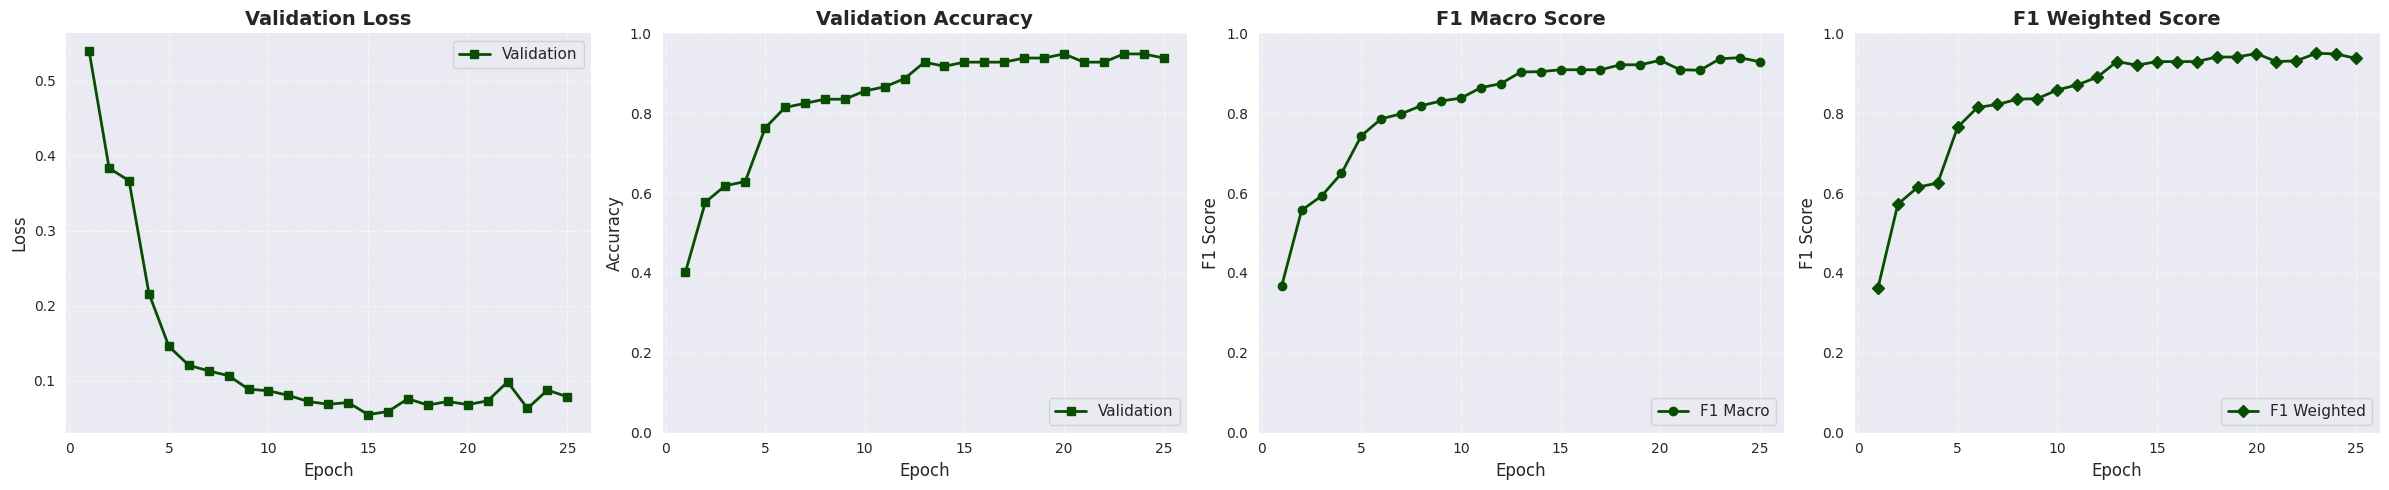

Fold 4 best F1: 0.9390

---------------------------------------------- Fold 5 ----------------------------------------------
Train distribution: [30, 91, 53, 219, 61, 62, 69]
Val distribution: [5, 16, 9, 36, 10, 10, 11]


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.11it/s]


Fold 5 | Epoch 1 | Train Loss: 1.0362 | Train Acc: 20.14% | Val Loss: 0.4740 | Val Acc: 0.5670 | Val F1 Macro: 0.5825 | Val F1 Weighted: 0.5713


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.59it/s]


Fold 5 | Epoch 2 | Train Loss: 0.6921 | Train Acc: 33.85% | Val Loss: 0.3263 | Val Acc: 0.6598 | Val F1 Macro: 0.6576 | Val F1 Weighted: 0.6526


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.80it/s]


Fold 5 | Epoch 3 | Train Loss: 0.6244 | Train Acc: 36.46% | Val Loss: 0.3175 | Val Acc: 0.6289 | Val F1 Macro: 0.6417 | Val F1 Weighted: 0.6186


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.33it/s]


Fold 5 | Epoch 4 | Train Loss: 0.4844 | Train Acc: 46.53% | Val Loss: 0.1724 | Val Acc: 0.6082 | Val F1 Macro: 0.6726 | Val F1 Weighted: 0.5976


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


Fold 5 | Epoch 5 | Train Loss: 0.3056 | Train Acc: 53.65% | Val Loss: 0.0976 | Val Acc: 0.7835 | Val F1 Macro: 0.7972 | Val F1 Weighted: 0.7966


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.15it/s]


Fold 5 | Epoch 6 | Train Loss: 0.1760 | Train Acc: 63.19% | Val Loss: 0.0986 | Val Acc: 0.7629 | Val F1 Macro: 0.7855 | Val F1 Weighted: 0.7774


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.73it/s]


Fold 5 | Epoch 7 | Train Loss: 0.1950 | Train Acc: 69.10% | Val Loss: 0.0737 | Val Acc: 0.8454 | Val F1 Macro: 0.8452 | Val F1 Weighted: 0.8591


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.03it/s]


Fold 5 | Epoch 8 | Train Loss: 0.1696 | Train Acc: 69.27% | Val Loss: 0.0723 | Val Acc: 0.8557 | Val F1 Macro: 0.8509 | Val F1 Weighted: 0.8683


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.89it/s]


Fold 5 | Epoch 9 | Train Loss: 0.1415 | Train Acc: 73.61% | Val Loss: 0.0623 | Val Acc: 0.8454 | Val F1 Macro: 0.8481 | Val F1 Weighted: 0.8568


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.99it/s]


Fold 5 | Epoch 10 | Train Loss: 0.1644 | Train Acc: 77.43% | Val Loss: 0.0378 | Val Acc: 0.8866 | Val F1 Macro: 0.8822 | Val F1 Weighted: 0.8927


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.75it/s]


Fold 5 | Epoch 11 | Train Loss: 0.1101 | Train Acc: 82.81% | Val Loss: 0.0316 | Val Acc: 0.8969 | Val F1 Macro: 0.8997 | Val F1 Weighted: 0.9014


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.74it/s]


Fold 5 | Epoch 12 | Train Loss: 0.1132 | Train Acc: 81.42% | Val Loss: 0.0426 | Val Acc: 0.8969 | Val F1 Macro: 0.8981 | Val F1 Weighted: 0.9014


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.99it/s]


Fold 5 | Epoch 13 | Train Loss: 0.0906 | Train Acc: 82.12% | Val Loss: 0.0407 | Val Acc: 0.8763 | Val F1 Macro: 0.8776 | Val F1 Weighted: 0.8816


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.03it/s]


Fold 5 | Epoch 14 | Train Loss: 0.0754 | Train Acc: 85.07% | Val Loss: 0.0195 | Val Acc: 0.9175 | Val F1 Macro: 0.9163 | Val F1 Weighted: 0.9191


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.00it/s]


Fold 5 | Epoch 15 | Train Loss: 0.0841 | Train Acc: 87.15% | Val Loss: 0.0383 | Val Acc: 0.8969 | Val F1 Macro: 0.8914 | Val F1 Weighted: 0.9006


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.01it/s]


Fold 5 | Epoch 16 | Train Loss: 0.0480 | Train Acc: 88.37% | Val Loss: 0.0435 | Val Acc: 0.9278 | Val F1 Macro: 0.9167 | Val F1 Weighted: 0.9302


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.67it/s]


Fold 5 | Epoch 17 | Train Loss: 0.0487 | Train Acc: 89.58% | Val Loss: 0.0371 | Val Acc: 0.9381 | Val F1 Macro: 0.9324 | Val F1 Weighted: 0.9397


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.01it/s]


Fold 5 | Epoch 18 | Train Loss: 0.0495 | Train Acc: 91.15% | Val Loss: 0.0478 | Val Acc: 0.9381 | Val F1 Macro: 0.9243 | Val F1 Weighted: 0.9397


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.24it/s]


Fold 5 | Epoch 19 | Train Loss: 0.0421 | Train Acc: 91.32% | Val Loss: 0.0374 | Val Acc: 0.9381 | Val F1 Macro: 0.9243 | Val F1 Weighted: 0.9397


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.84it/s]


Fold 5 | Epoch 20 | Train Loss: 0.0248 | Train Acc: 92.88% | Val Loss: 0.0334 | Val Acc: 0.9278 | Val F1 Macro: 0.9167 | Val F1 Weighted: 0.9302


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.99it/s]


Fold 5 | Epoch 21 | Train Loss: 0.0622 | Train Acc: 92.19% | Val Loss: 0.0373 | Val Acc: 0.9278 | Val F1 Macro: 0.9167 | Val F1 Weighted: 0.9302


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.80it/s]


Fold 5 | Epoch 22 | Train Loss: 0.0457 | Train Acc: 92.19% | Val Loss: 0.0383 | Val Acc: 0.9381 | Val F1 Macro: 0.9368 | Val F1 Weighted: 0.9388


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.68it/s]


Fold 5 | Epoch 23 | Train Loss: 0.0518 | Train Acc: 92.19% | Val Loss: 0.0372 | Val Acc: 0.9588 | Val F1 Macro: 0.9498 | Val F1 Weighted: 0.9591


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.04it/s]


Fold 5 | Epoch 24 | Train Loss: 0.0364 | Train Acc: 93.06% | Val Loss: 0.0305 | Val Acc: 0.9485 | Val F1 Macro: 0.9416 | Val F1 Weighted: 0.9493


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.69it/s]


------------ Classification Report ------------


Fold 5 | Epoch 25 | Train Loss: 0.0446 | Train Acc: 92.88% | Val Loss: 0.0384 | Val Acc: 0.9381 | Val F1 Macro: 0.9359 | Val F1 Weighted: 0.9407


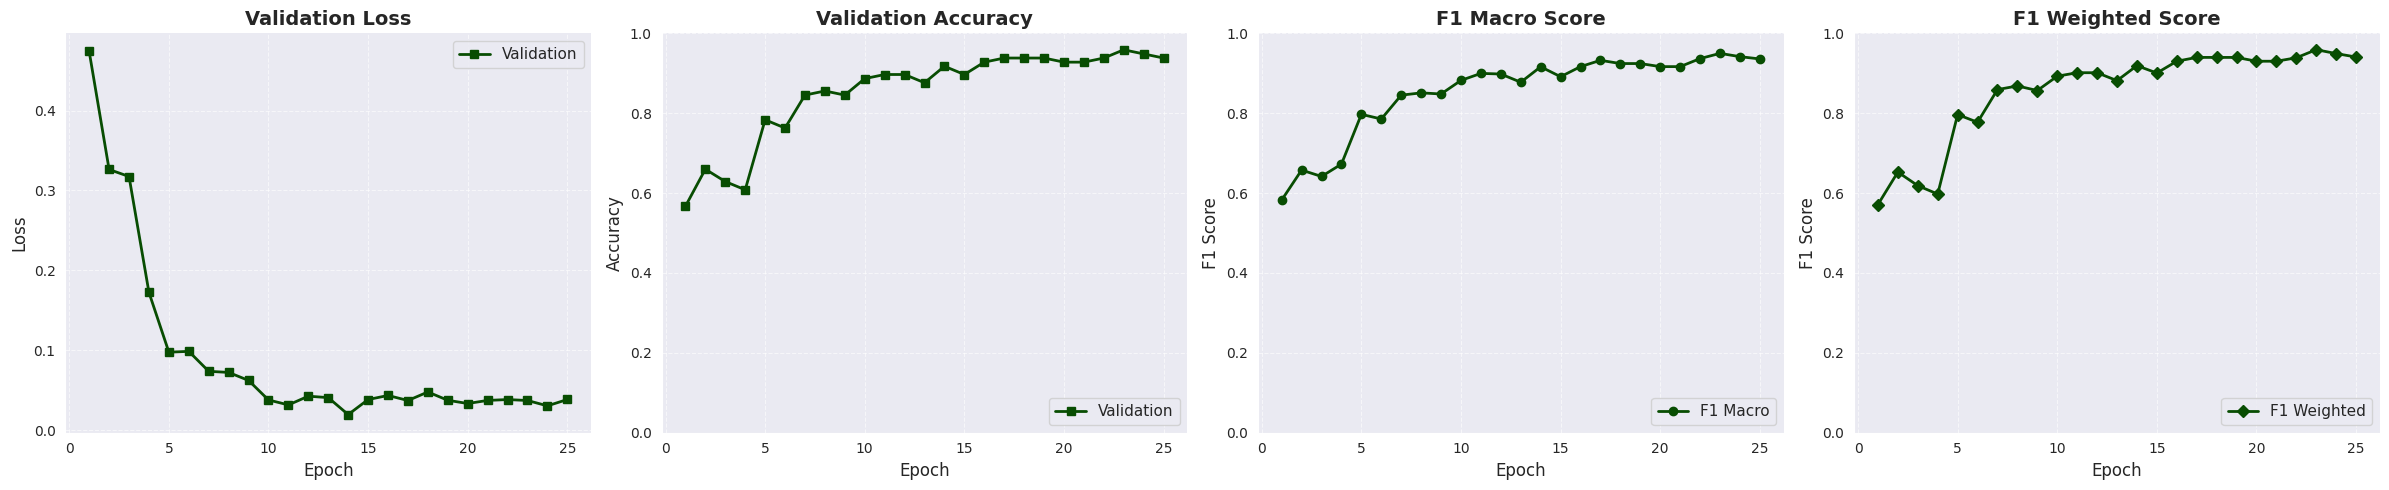

Fold 5 best F1: 0.9498

---------------------------------------------- Fold 6 ----------------------------------------------
Train distribution: [30, 92, 53, 219, 61, 61, 69]
Val distribution: [5, 15, 9, 36, 10, 11, 11]


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.26it/s]


Fold 6 | Epoch 1 | Train Loss: 1.0465 | Train Acc: 23.96% | Val Loss: 0.4392 | Val Acc: 0.6495 | Val F1 Macro: 0.6121 | Val F1 Weighted: 0.6387


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.53it/s]


Fold 6 | Epoch 2 | Train Loss: 0.8274 | Train Acc: 35.59% | Val Loss: 0.3108 | Val Acc: 0.6907 | Val F1 Macro: 0.7165 | Val F1 Weighted: 0.6932


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.27it/s]


Fold 6 | Epoch 3 | Train Loss: 0.6393 | Train Acc: 45.14% | Val Loss: 0.2738 | Val Acc: 0.6804 | Val F1 Macro: 0.7043 | Val F1 Weighted: 0.6828


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.42it/s]


Fold 6 | Epoch 4 | Train Loss: 0.4962 | Train Acc: 49.65% | Val Loss: 0.1350 | Val Acc: 0.8144 | Val F1 Macro: 0.8014 | Val F1 Weighted: 0.8188


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.70it/s]


Fold 6 | Epoch 5 | Train Loss: 0.2670 | Train Acc: 63.72% | Val Loss: 0.0889 | Val Acc: 0.8454 | Val F1 Macro: 0.8366 | Val F1 Weighted: 0.8516


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.70it/s]


Fold 6 | Epoch 6 | Train Loss: 0.2149 | Train Acc: 67.19% | Val Loss: 0.0760 | Val Acc: 0.8660 | Val F1 Macro: 0.8510 | Val F1 Weighted: 0.8724


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


Fold 6 | Epoch 7 | Train Loss: 0.1937 | Train Acc: 70.66% | Val Loss: 0.0738 | Val Acc: 0.8763 | Val F1 Macro: 0.8648 | Val F1 Weighted: 0.8833


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.57it/s]


Fold 6 | Epoch 8 | Train Loss: 0.1507 | Train Acc: 72.92% | Val Loss: 0.0672 | Val Acc: 0.8866 | Val F1 Macro: 0.8767 | Val F1 Weighted: 0.8925


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.55it/s]


Fold 6 | Epoch 9 | Train Loss: 0.1575 | Train Acc: 71.88% | Val Loss: 0.0620 | Val Acc: 0.8866 | Val F1 Macro: 0.8809 | Val F1 Weighted: 0.8948


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.46it/s]


Fold 6 | Epoch 10 | Train Loss: 0.1619 | Train Acc: 79.51% | Val Loss: 0.0621 | Val Acc: 0.9175 | Val F1 Macro: 0.9146 | Val F1 Weighted: 0.9185


Validating: 100%|██████████| 7/7 [00:00<00:00,  7.93it/s]


Fold 6 | Epoch 11 | Train Loss: 0.1306 | Train Acc: 78.47% | Val Loss: 0.0718 | Val Acc: 0.8969 | Val F1 Macro: 0.8945 | Val F1 Weighted: 0.8987


Validating: 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Fold 6 | Epoch 12 | Train Loss: 0.0917 | Train Acc: 81.25% | Val Loss: 0.0607 | Val Acc: 0.9278 | Val F1 Macro: 0.9104 | Val F1 Weighted: 0.9290


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.51it/s]


Fold 6 | Epoch 13 | Train Loss: 0.0894 | Train Acc: 84.20% | Val Loss: 0.0470 | Val Acc: 0.9381 | Val F1 Macro: 0.9367 | Val F1 Weighted: 0.9387


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.52it/s]


Fold 6 | Epoch 14 | Train Loss: 0.0788 | Train Acc: 88.02% | Val Loss: 0.0532 | Val Acc: 0.9588 | Val F1 Macro: 0.9597 | Val F1 Weighted: 0.9591


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.51it/s]


Fold 6 | Epoch 15 | Train Loss: 0.0420 | Train Acc: 92.36% | Val Loss: 0.0441 | Val Acc: 0.9691 | Val F1 Macro: 0.9679 | Val F1 Weighted: 0.9694


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.58it/s]


Fold 6 | Epoch 16 | Train Loss: 0.0306 | Train Acc: 93.23% | Val Loss: 0.0460 | Val Acc: 0.9485 | Val F1 Macro: 0.9451 | Val F1 Weighted: 0.9488


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.34it/s]


Fold 6 | Epoch 17 | Train Loss: 0.0403 | Train Acc: 90.80% | Val Loss: 0.0435 | Val Acc: 0.9485 | Val F1 Macro: 0.9510 | Val F1 Weighted: 0.9497


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.58it/s]


Fold 6 | Epoch 18 | Train Loss: 0.0430 | Train Acc: 93.06% | Val Loss: 0.0402 | Val Acc: 0.9588 | Val F1 Macro: 0.9584 | Val F1 Weighted: 0.9593


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.57it/s]


Fold 6 | Epoch 19 | Train Loss: 0.0397 | Train Acc: 93.06% | Val Loss: 0.0403 | Val Acc: 0.9485 | Val F1 Macro: 0.9519 | Val F1 Weighted: 0.9491


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.41it/s]


Fold 6 | Epoch 20 | Train Loss: 0.0237 | Train Acc: 93.40% | Val Loss: 0.0443 | Val Acc: 0.9485 | Val F1 Macro: 0.9519 | Val F1 Weighted: 0.9491


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.53it/s]


Fold 6 | Epoch 21 | Train Loss: 0.0284 | Train Acc: 93.40% | Val Loss: 0.0446 | Val Acc: 0.9485 | Val F1 Macro: 0.9519 | Val F1 Weighted: 0.9491


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.46it/s]


Fold 6 | Epoch 22 | Train Loss: 0.0253 | Train Acc: 95.66% | Val Loss: 0.0458 | Val Acc: 0.9485 | Val F1 Macro: 0.9526 | Val F1 Weighted: 0.9508
Early stopping at epoch 21


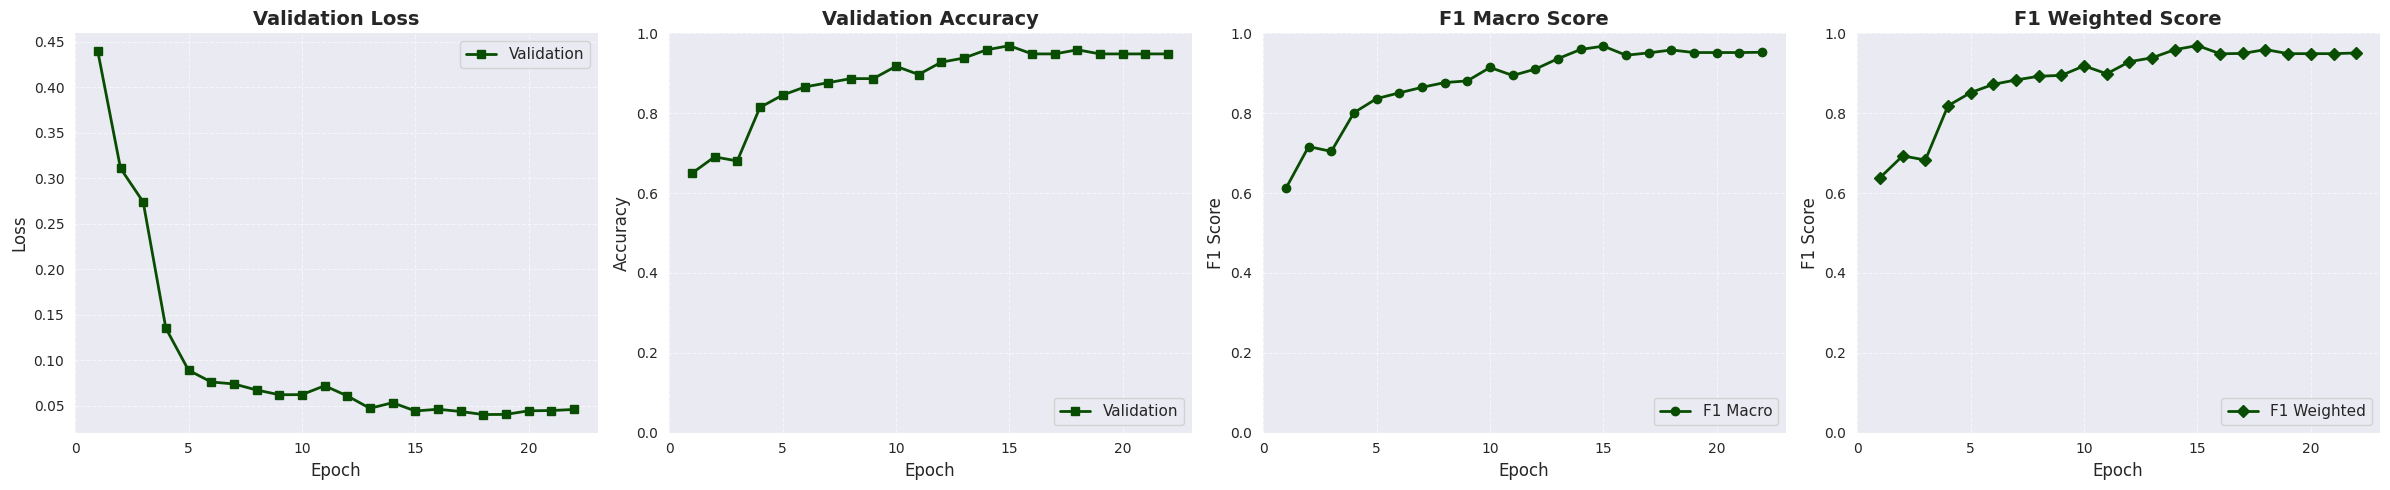

Fold 6 best F1: 0.9679

---------------------------------------------- Fold 7 ----------------------------------------------
Train distribution: [30, 92, 54, 219, 61, 61, 68]
Val distribution: [5, 15, 8, 36, 10, 11, 12]


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.09it/s]


Fold 7 | Epoch 1 | Train Loss: 1.0511 | Train Acc: 18.23% | Val Loss: 0.5275 | Val Acc: 0.3814 | Val F1 Macro: 0.3805 | Val F1 Weighted: 0.3640


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.43it/s]


Fold 7 | Epoch 2 | Train Loss: 0.7506 | Train Acc: 35.07% | Val Loss: 0.3265 | Val Acc: 0.5361 | Val F1 Macro: 0.5696 | Val F1 Weighted: 0.5171


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.20it/s]


Fold 7 | Epoch 3 | Train Loss: 0.6391 | Train Acc: 37.15% | Val Loss: 0.3118 | Val Acc: 0.5670 | Val F1 Macro: 0.5889 | Val F1 Weighted: 0.5638


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.21it/s]


Fold 7 | Epoch 4 | Train Loss: 0.4707 | Train Acc: 45.83% | Val Loss: 0.1375 | Val Acc: 0.7526 | Val F1 Macro: 0.7298 | Val F1 Weighted: 0.7503


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


Fold 7 | Epoch 5 | Train Loss: 0.3396 | Train Acc: 57.47% | Val Loss: 0.1225 | Val Acc: 0.7629 | Val F1 Macro: 0.7364 | Val F1 Weighted: 0.7593


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.00it/s]


Fold 7 | Epoch 6 | Train Loss: 0.2354 | Train Acc: 63.19% | Val Loss: 0.1110 | Val Acc: 0.8144 | Val F1 Macro: 0.8011 | Val F1 Weighted: 0.8178


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.77it/s]


Fold 7 | Epoch 7 | Train Loss: 0.2298 | Train Acc: 69.10% | Val Loss: 0.0947 | Val Acc: 0.8041 | Val F1 Macro: 0.7999 | Val F1 Weighted: 0.8110


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.31it/s]


Fold 7 | Epoch 8 | Train Loss: 0.1652 | Train Acc: 72.05% | Val Loss: 0.0829 | Val Acc: 0.8144 | Val F1 Macro: 0.8051 | Val F1 Weighted: 0.8179


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.28it/s]


Fold 7 | Epoch 9 | Train Loss: 0.1212 | Train Acc: 76.56% | Val Loss: 0.0896 | Val Acc: 0.8351 | Val F1 Macro: 0.8234 | Val F1 Weighted: 0.8392


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.08it/s]


Fold 7 | Epoch 10 | Train Loss: 0.1563 | Train Acc: 73.61% | Val Loss: 0.1004 | Val Acc: 0.8763 | Val F1 Macro: 0.8622 | Val F1 Weighted: 0.8774


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.20it/s]


Fold 7 | Epoch 11 | Train Loss: 0.1252 | Train Acc: 80.56% | Val Loss: 0.0925 | Val Acc: 0.8969 | Val F1 Macro: 0.8781 | Val F1 Weighted: 0.8969


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.25it/s]


Fold 7 | Epoch 12 | Train Loss: 0.0988 | Train Acc: 84.72% | Val Loss: 0.1068 | Val Acc: 0.8969 | Val F1 Macro: 0.8816 | Val F1 Weighted: 0.8972


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.17it/s]


Fold 7 | Epoch 13 | Train Loss: 0.0896 | Train Acc: 89.06% | Val Loss: 0.1197 | Val Acc: 0.8969 | Val F1 Macro: 0.8741 | Val F1 Weighted: 0.8976


Validating: 100%|██████████| 7/7 [00:00<00:00,  7.97it/s]


Fold 7 | Epoch 14 | Train Loss: 0.0543 | Train Acc: 90.62% | Val Loss: 0.1212 | Val Acc: 0.9278 | Val F1 Macro: 0.9079 | Val F1 Weighted: 0.9293


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


Fold 7 | Epoch 15 | Train Loss: 0.0638 | Train Acc: 90.45% | Val Loss: 0.0997 | Val Acc: 0.9485 | Val F1 Macro: 0.9337 | Val F1 Weighted: 0.9478


Validating: 100%|██████████| 7/7 [00:00<00:00,  9.02it/s]


Fold 7 | Epoch 16 | Train Loss: 0.0607 | Train Acc: 92.19% | Val Loss: 0.1134 | Val Acc: 0.9691 | Val F1 Macro: 0.9596 | Val F1 Weighted: 0.9678


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.70it/s]


Fold 7 | Epoch 17 | Train Loss: 0.0559 | Train Acc: 92.71% | Val Loss: 0.1105 | Val Acc: 0.9485 | Val F1 Macro: 0.9296 | Val F1 Weighted: 0.9472


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


Fold 7 | Epoch 18 | Train Loss: 0.0336 | Train Acc: 93.92% | Val Loss: 0.1048 | Val Acc: 0.9485 | Val F1 Macro: 0.9337 | Val F1 Weighted: 0.9478


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.23it/s]


Fold 7 | Epoch 19 | Train Loss: 0.0332 | Train Acc: 93.58% | Val Loss: 0.1186 | Val Acc: 0.9381 | Val F1 Macro: 0.9227 | Val F1 Weighted: 0.9372


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.95it/s]


Fold 7 | Epoch 20 | Train Loss: 0.0228 | Train Acc: 94.10% | Val Loss: 0.1185 | Val Acc: 0.9485 | Val F1 Macro: 0.9337 | Val F1 Weighted: 0.9478


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.84it/s]


Fold 7 | Epoch 21 | Train Loss: 0.0329 | Train Acc: 94.97% | Val Loss: 0.1103 | Val Acc: 0.9588 | Val F1 Macro: 0.9516 | Val F1 Weighted: 0.9578


Validating: 100%|██████████| 7/7 [00:00<00:00,  8.79it/s]


Fold 7 | Epoch 22 | Train Loss: 0.0601 | Train Acc: 93.92% | Val Loss: 0.1059 | Val Acc: 0.9381 | Val F1 Macro: 0.9392 | Val F1 Weighted: 0.9386


Validating: 100%|██████████| 7/7 [00:00<00:00,  7.66it/s]


Fold 7 | Epoch 23 | Train Loss: 0.0210 | Train Acc: 94.62% | Val Loss: 0.1169 | Val Acc: 0.9485 | Val F1 Macro: 0.9370 | Val F1 Weighted: 0.9485
Early stopping at epoch 22


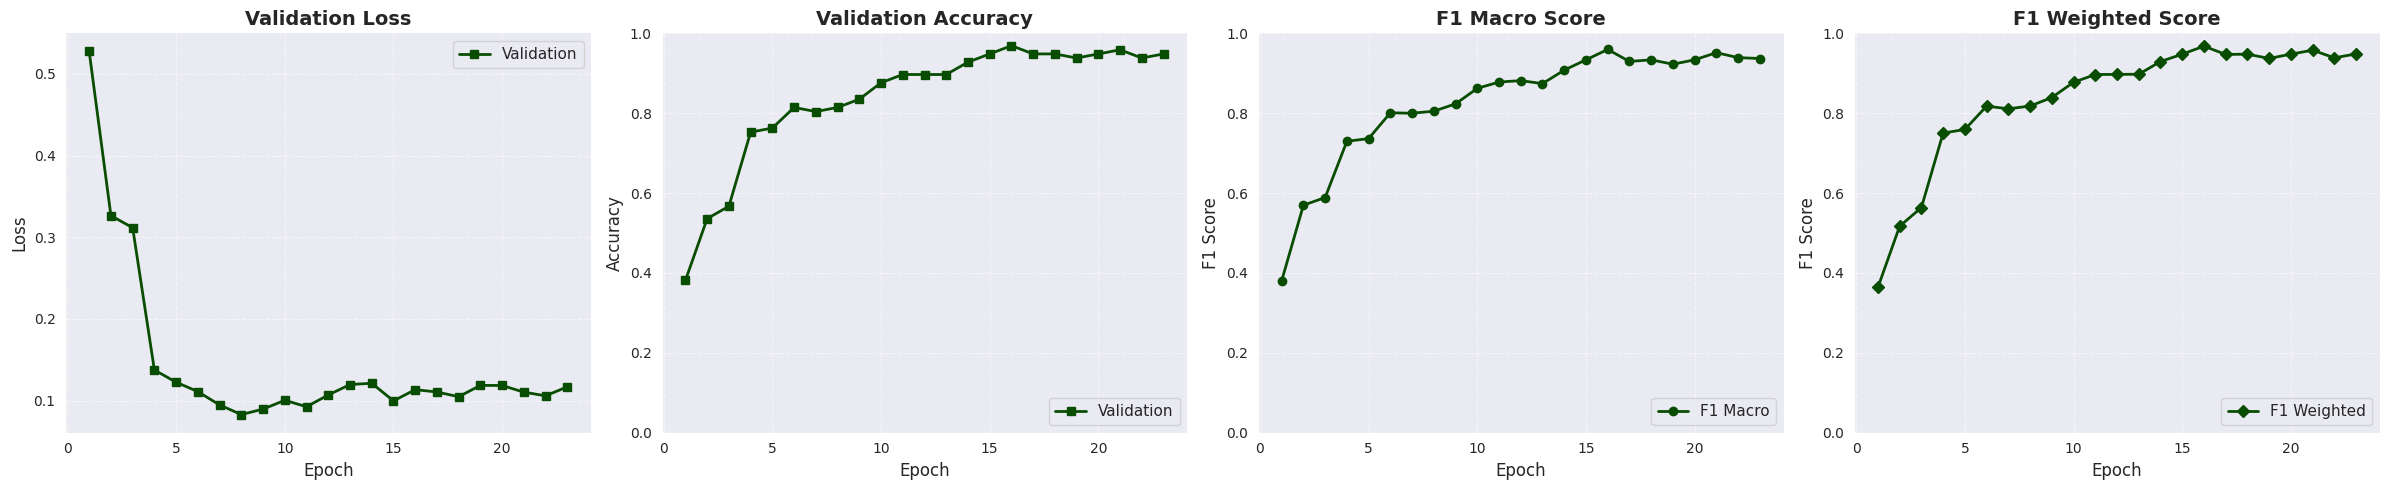

Fold 7 best F1: 0.9596

Cross-validation results:
Mean F1: 0.9562 ± 0.0176
Individual fold scores: [0.9912403317491381, 0.9362172981163878, 0.9493256190231233, 0.939010939641036, 0.9498292057472267, 0.967935116967469, 0.9596136459871139]


In [9]:
fold_scores = []
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df.label)):
    print(f'\n---------------------------------------------- Fold {fold+1} ----------------------------------------------')
    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]

    # Print fold class distribution
    print(f"Train distribution: {train_df['label'].value_counts().sort_index().tolist()}")
    print(f"Val distribution: {val_df['label'].value_counts().sort_index().tolist()}")

    train_ds = SheepDataset(train_df, CFG.train_dir, get_train_transforms())
    val_ds = SheepDataset(val_df, CFG.train_dir, get_valid_transforms())

    train_loader = DataLoader(
        train_ds, 
        batch_size=CFG.batch_size, 
        shuffle=True, 
        num_workers=4,
        pin_memory=True,
        drop_last=True
    )
    val_loader = DataLoader(
        val_ds, 
        batch_size=CFG.batch_size, 
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    model = ViTClassifier(CFG.model_name, CFG.num_classes).to(CFG.device)
    optimizer, scheduler = get_optimizer_scheduler(model, train_loader, CFG.epochs)
    scaler = torch.amp.GradScaler(device=CFG.device)
    early_stopping = EarlyStopping(patience=CFG.patience)

    # Initialize history tracking for this fold
    history = {
        'val_loss': [],
        'val_acc': [],
        'val_f1_macro': [],
        'val_f1_weighted': []
    }

    best_f1 = 0

    for epoch in range(CFG.epochs):
        train_loss, train_acc = train_one_epoch(
            model, train_loader, optimizer, criterion, scheduler, scaler, epoch
        )

        # Save class report only at the last epoch or every 5th
        save_report = (epoch == CFG.epochs - 1)
        val_f1_macro, val_f1_weighted, val_acc, val_loss, report_txt = evaluate(
            model, val_loader, criterion,
            class_report=save_report
        )

        # Store metrics in history
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1_macro'].append(val_f1_macro)
        history['val_f1_weighted'].append(val_f1_weighted)

        print(f'Fold {fold+1} | Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | '
              f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | '
              f'Val F1 Macro: {val_f1_macro:.4f} | Val F1 Weighted: {val_f1_weighted:.4f}')

        if val_f1_macro > best_f1:
            best_f1 = val_f1_macro
            torch.save(model.state_dict(), os.path.join(CFG.models_dir, f'best_model_fold{fold}.pth'))
            # Save best classification report
            if report_txt:
                report_path = os.path.join(CFG.results_dir, f'fold_{fold}_report.txt')
                with open(report_path, "w") as f:
                    f.write(report_txt)

        # Early stopping
        if early_stopping(val_f1_macro, model):
            print(f'Early stopping at epoch {epoch}')
            break

    # Plot metrics for this fold
    plot_metrics(history, f"folde_{fold+1}_metrics.png")

    fold_scores.append(best_f1)
    print(f'Fold {fold+1} best F1: {best_f1:.4f}')

print(f'\nCross-validation results:')
print(f'Mean F1: {np.mean(fold_scores):.4f} ± {np.std(fold_scores):.4f}')
print(f'Individual fold scores: {fold_scores}')

In [10]:
val_f1_macro, val_f1_weighted, val_acc, val_loss, report_txt = evaluate(
        model, val_loader, criterion,
        class_report=True
    )

Validating: 100%|██████████| 7/7 [00:00<00:00,  8.67it/s]



------------ Classification Report ------------


## Ensemble Prediction

In [11]:
def predict_test(model_paths):
    df = pd.read_csv(CFG.train_csv)
    label2idx = {label: i for i, label in enumerate(sorted(df['label'].unique()))}
    idx2label = {v: k for k, v in label2idx.items()}

    test_files = sorted([f for f in os.listdir(CFG.test_dir) if f.lower().endswith('.jpg')])
    test_ds = SheepDataset(image_dir=CFG.test_dir, transform=get_valid_transforms(), is_test=True)
    test_ds.img_files = test_files

    test_loader = DataLoader(
        test_ds, 
        batch_size=CFG.batch_size, 
        shuffle=False, 
        num_workers=4, 
        pin_memory=True
    )

    all_preds = []
    all_confidences = []
    all_filenames = []

    models = []
    for model_file in model_paths:
        model_path = os.path.join(CFG.models_dir, model_file)
        model = ViTClassifier(CFG.model_name, CFG.num_classes).to(CFG.device)
        state_dict = torch.load(model_path, map_location=CFG.device, weights_only=True)
        model.load_state_dict(state_dict)
        model.eval()
        models.append(model)

    # Predict in batches
    for images, filenames in tqdm(test_loader, desc="Predicting"):
        images = images.to(CFG.device)
        batch_logits = []

        with torch.no_grad():
            for model in models:
                with torch.amp.autocast(device_type=CFG.device):
                    outputs = model(images)
                    probs = torch.softmax(outputs, dim=1)
                    batch_logits.append(probs.cpu().numpy())

        avg_probs = np.mean(batch_logits, axis=0)

        preds = np.argmax(avg_probs, axis=1)
        confidences = np.max(avg_probs, axis=1)

        all_preds.extend(preds)
        all_confidences.extend(confidences)
        all_filenames.extend(filenames)

    all_labels = [idx2label[pred] for pred in all_preds]

    df1 = pd.DataFrame({
        'filename': all_filenames,
        'label': all_labels
    })
    df2 = pd.DataFrame({
        'filename': all_filenames,
        'label': all_labels,
        'confidence': all_confidences
    })

    os.makedirs(CFG.results_dir, exist_ok=True)
    out1 = os.path.join(CFG.results_dir, 'submission.csv')
    df1.to_csv(out1, index=False)

    out2 = os.path.join(CFG.results_dir, 'submission_with_confidence.csv')
    df2.to_csv(out2, index=False)

    # Print some statistics
    print(f"Total predictions: {len(all_preds)}")
    print(f"Average confidence: {np.mean(all_confidences):.4f}")
    print(f"Min confidence: {np.min(all_confidences):.4f}")
    print(f"Max confidence: {np.max(all_confidences):.4f}")

    return df1, df2

In [12]:
model_files = [f for f in os.listdir(CFG.models_dir) if f.endswith('.pth')]
df, df_conf = predict_test(model_files)

Predicting: 100%|██████████| 9/9 [00:03<00:00,  2.29it/s]

Total predictions: 144
Average confidence: 0.8550
Min confidence: 0.3105
Max confidence: 0.9983


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


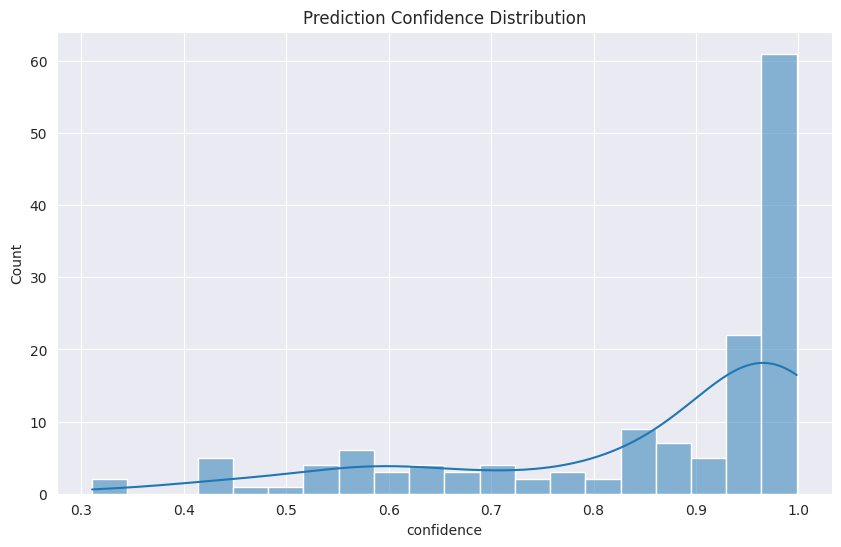

In [13]:
# Plot confidence distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_conf['confidence'], bins=20, kde=True)
plt.title("Prediction Confidence Distribution")
plt.show()

In [14]:
# low-confidence samples
low_conf = df_conf[df_conf['confidence'] < 0.7]
display(low_conf.head(10))

filename    label  confidence
3   06e1783d.jpg    Harri    0.596455
7   1081d46a.jpg   Naeimi    0.669922
13  163f0957.jpg     Goat    0.575754
19  18a45994.jpg    Roman    0.339280
21  226dc6ee.jpg   Naeimi    0.537295
24  24f34b9e.jpg  Sawakni    0.564695
25  2735eb07.jpg     Goat    0.692664
28  2b5fa46a.jpg     Goat    0.427861
37  3be8b97b.jpg  Sawakni    0.609249
38  3c5436f0.jpg   Naeimi    0.669933

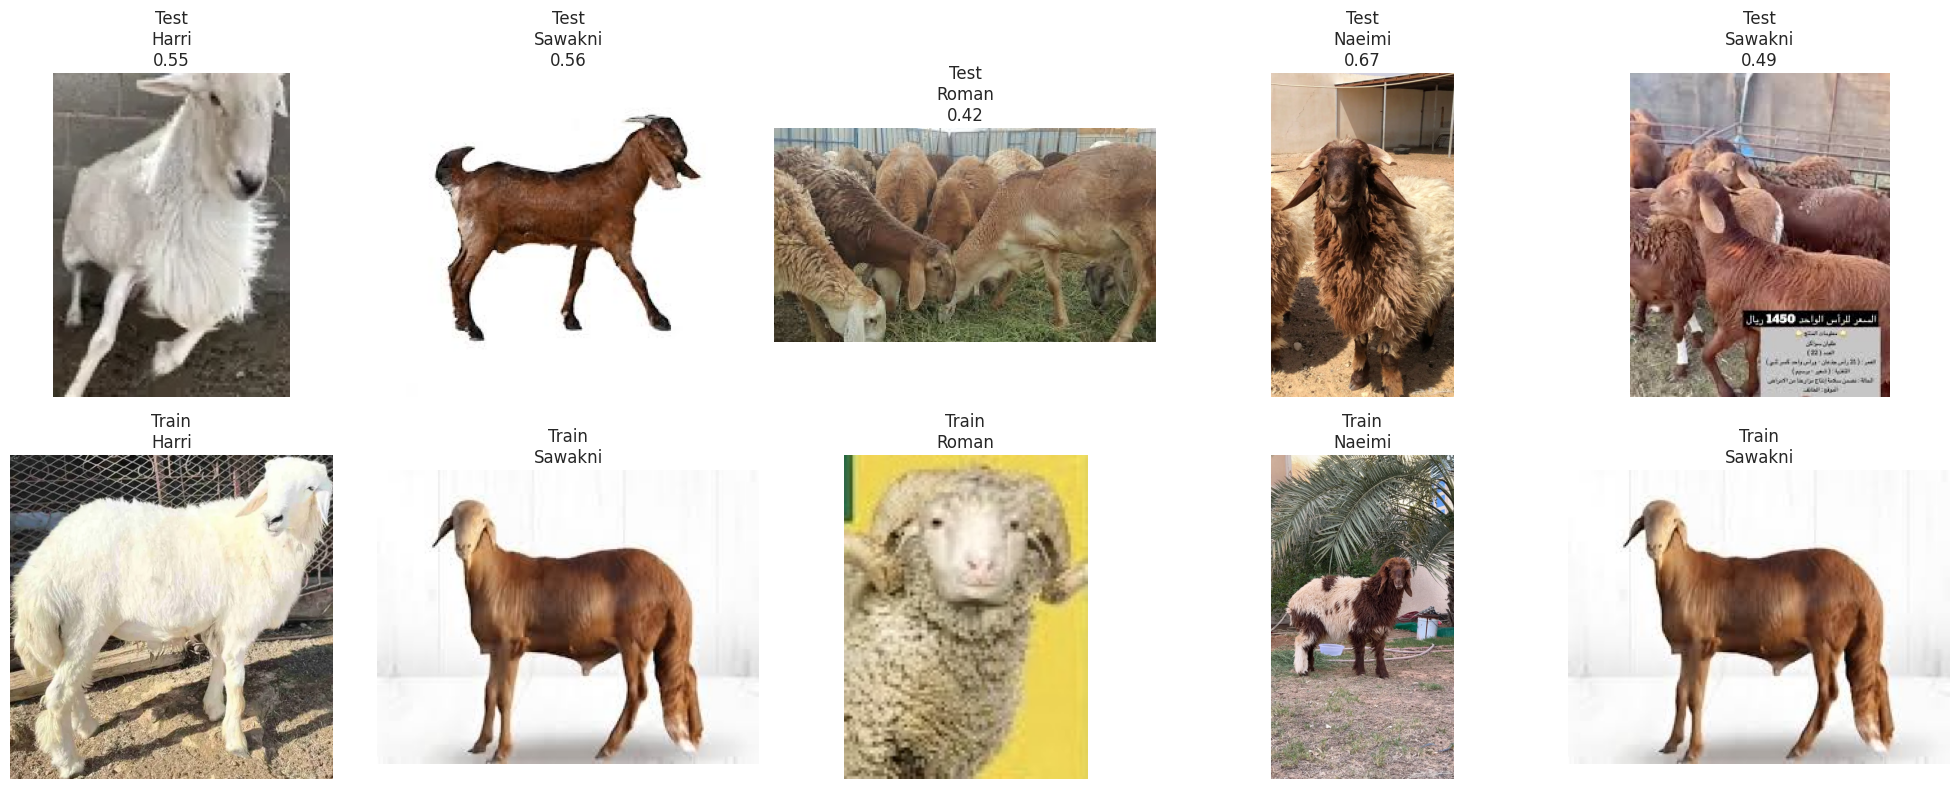

In [15]:
test_df = pd.read_csv("/kaggle/working/results/submission_with_confidence.csv")
train_df = pd.read_csv(CFG.train_csv)
test_dir = Path(CFG.test_dir)
train_dir = Path(CFG.train_dir)

# plot 5 random samples from low confidence data
random = low_conf.sample(n=5)

_, axes = plt.subplots(2, 5, figsize=(20, 8))

for i, (_, row) in enumerate(random.iterrows()):

    # Plot 5 random predictions
    img_test_path = test_dir / row.filename
    img_test = Image.open(img_test_path)
    axes[0, i].imshow(img_test)
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Test\n{row.label}\n{row.confidence:.2f}")

    # Find train image with the same label for comparision
    train_match = train_df[train_df['label'] == row.label]
    train_fname = train_match.iloc[0]['filename']
    img_train_path = train_dir / train_fname
    img_train = Image.open(img_train_path)
    axes[1, i].imshow(img_train)
    axes[1, i].axis('off')
    axes[1, i].set_title(f"Train\n{row.label}")

plt.tight_layout()
plt.show()

In [16]:
# high-confidence samples
high_conf = df_conf[df_conf['confidence'] > 0.7]
display(high_conf.head(10))

filename    label  confidence
0   0306fa89.jpg  Barbari    0.995277
1   0345e3ca.jpg    Roman    0.955863
2   0551a473.jpg  Sawakni    0.995467
4   08b9981b.jpg  Barbari    0.934636
5   0cfc6a1e.jpg     Goat    0.930513
6   100bd43a.jpg    Roman    0.772783
8   10e27bf7.jpg    Roman    0.935281
9   11bc3308.jpg  Sawakni    0.996102
10  11dbafc4.jpg     Goat    0.844391
11  1432d91c.jpg  Barbari    0.932193

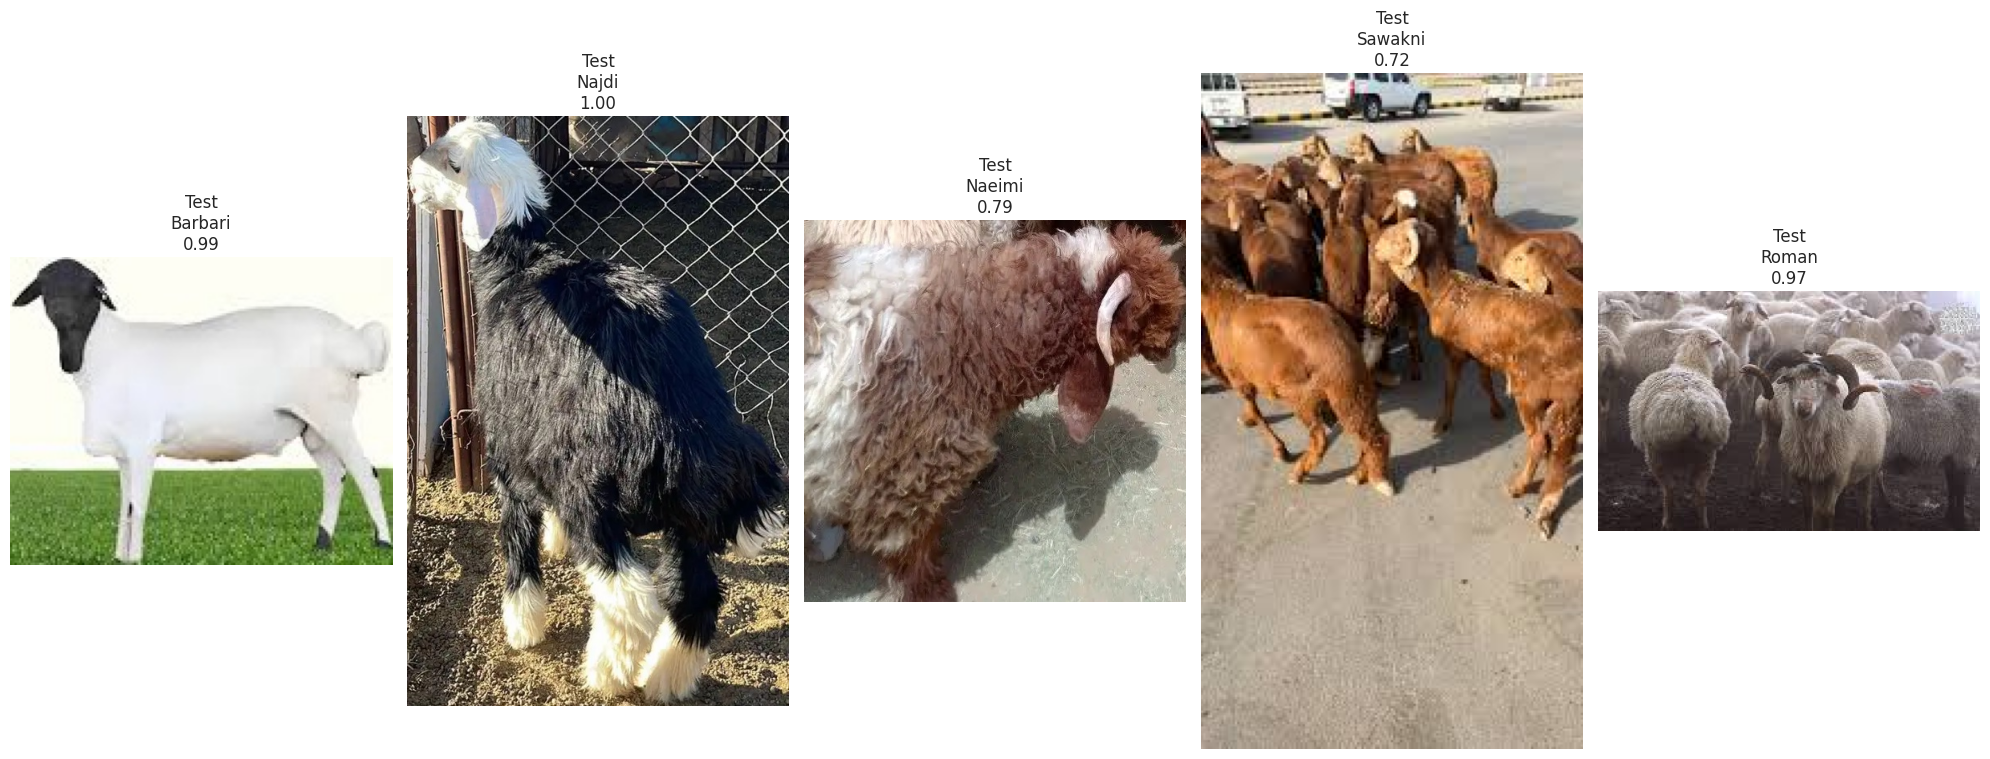

In [17]:
# plot 5 random samples from high confidence data
random = high_conf.sample(n=5)

_, axes = plt.subplots(1, 5, figsize=(20, 8))

for i, (_, row) in enumerate(random.iterrows()):

    # Plot 5 random predictions
    img_test_path = test_dir / row.filename
    img_test = Image.open(img_test_path)
    axes[i].imshow(img_test)
    axes[i].axis('off')
    axes[i].set_title(f"Test\n{row.label}\n{row.confidence:.2f}")

plt.tight_layout()
plt.show()

## Test Data Augmentation

In [18]:
def get_tta_transforms():
    def base_transform(aug=None):
        transforms = [A.Resize(CFG.img_size, CFG.img_size)]
        if aug:
            transforms.append(aug)
        transforms.extend([
            A.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
        return A.Compose(transforms)

    augmentations = [
        None,
        A.HorizontalFlip(p=1.0),
        A.VerticalFlip(p=1.0),
        A.Rotate(limit=90, p=1.0),
        A.ColorJitter(brightness=0.1, contrast=0.1, p=1.0),
        A.Compose([A.HorizontalFlip(p=1.0), A.Rotate(limit=15, p=1.0)])
    ]

    return [base_transform(aug) for aug in augmentations]


def predict_test_tta(model_paths, tta_steps=6):
    df = pd.read_csv(CFG.train_csv)
    label2idx = {label: i for i, label in enumerate(sorted(df['label'].unique()))}
    idx2label = {v: k for k, v in label2idx.items()}

    test_files = sorted([f for f in os.listdir(CFG.test_dir) if f.lower().endswith('.jpg')])
    tta_transforms = get_tta_transforms()[:tta_steps]

    models = []
    for model_file in model_paths:
        model = ViTClassifier(CFG.model_name, CFG.num_classes).to(CFG.device)
        state_dict = torch.load(os.path.join(CFG.models_dir, model_file),
                                map_location=CFG.device, weights_only=True)
        model.load_state_dict(state_dict)
        model.eval()
        models.append(model)

    all_preds, all_confidences, all_filenames = [], [], []

    for filename in tqdm(test_files, desc="Predicting with TTA"):
        img = np.array(Image.open(os.path.join(CFG.test_dir, filename)).convert('RGB'))
        tta_preds = []

        for transform in tta_transforms:
            input_tensor = transform(image=img)['image'].unsqueeze(0).to(CFG.device)
            with torch.no_grad(), torch.amp.autocast(device_type=CFG.device):
                outputs = [torch.softmax(m(input_tensor), dim=1).cpu().numpy() for m in models]
            tta_preds.append(np.mean(outputs, axis=0))

        final_pred = np.mean(tta_preds, axis=0)
        pred_class = np.argmax(final_pred, axis=1)[0]
        confidence = np.max(final_pred, axis=1)[0]

        all_preds.append(pred_class)
        all_confidences.append(confidence)
        all_filenames.append(filename)

    labels = [idx2label[p] for p in all_preds]
    df1 = pd.DataFrame({'filename': all_filenames, 'label': labels})
    df2 = pd.DataFrame({'filename': all_filenames, 'label': labels, 'confidence': all_confidences})

    os.makedirs(CFG.results_dir, exist_ok=True)
    df1.to_csv(os.path.join(CFG.results_dir, 'submission.csv'), index=False)
    df2.to_csv(os.path.join(CFG.results_dir, 'submission_with_confidence.csv'), index=False)

    print(f"Total predictions: {len(all_preds)}")
    print(f"Average confidence: {np.mean(all_confidences):.4f}")
    print(f"Min confidence: {np.min(all_confidences):.4f}")
    print(f"Max confidence: {np.max(all_confidences):.4f}")
    print(f"Used {len(tta_transforms)} TTA augmentations")

    return df1, df2

In [19]:
df_tta, df_conf_tta = predict_test_tta(model_files, tta_steps=6)

Predicting with TTA: 100%|██████████| 144/144 [00:53<00:00,  2.68it/s]

Total predictions: 144
Average confidence: 0.8438
Min confidence: 0.2986
Max confidence: 0.9980
Used 6 TTA augmentations


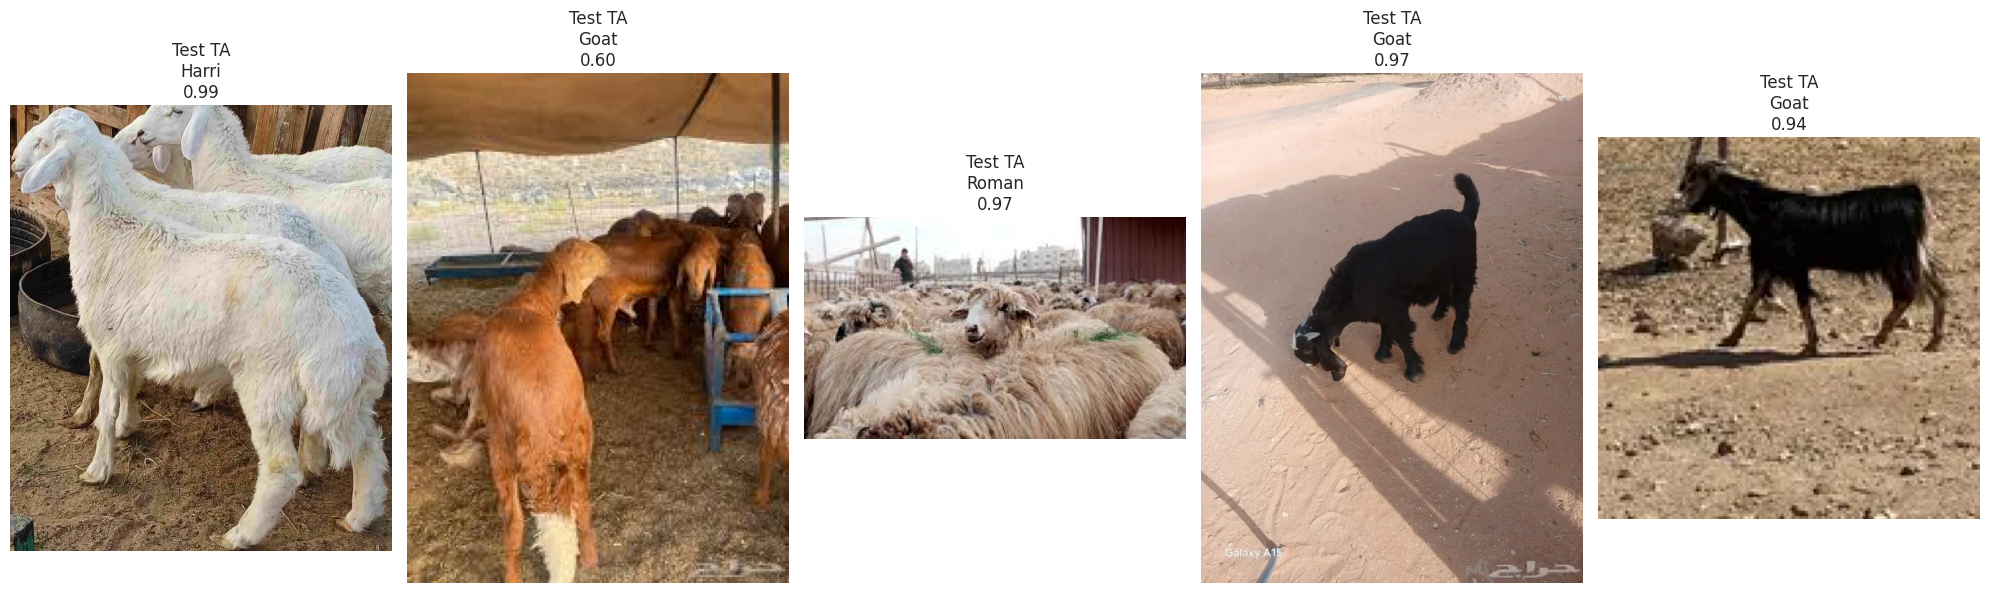

In [20]:
# plot 5 random samples
random = df_conf_tta.sample(n=5)

_, axes = plt.subplots(1, 5, figsize=(20, 8))

for i, (_, row) in enumerate(random.iterrows()):

    # Plot 5 random predictions
    img_test_path = test_dir / row.filename
    img_test = Image.open(img_test_path)
    axes[i].imshow(img_test)
    axes[i].axis('off')
    axes[i].set_title(f"Test TA\n{row.label}\n{row.confidence:.2f}")

plt.tight_layout()
plt.show()

__You can also find the repo for this project [here](https://github.com/ahmedsalim3/sheep-classification-challenge.git)__